<a href="https://colab.research.google.com/github/y2236li/Kiwi-Reasearch/blob/master/1D_Climber_with_Momentum_and_Param.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%load_ext autoreload

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
cd drive/My\ Drive/kiwi_research/kiwi_project

/content/drive/My Drive/kiwi_research/kiwi_project


In [5]:
from sklearn.preprocessing import MinMaxScaler
import os
import tensorflow as tf
import collections
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


In [0]:
def calAccuracy(x, XY):
  """
  Calculate the accuracy
  return: accuracy
  """
  X_train, X_test, Y_train, Y_test = XY
  pls2 = PLSRegression(n_components=x)
  pls2.fit(X_train, Y_train)
  Y_pred = pls2.predict(X_test)
  y = r2_score(Y_pred, Y_test)

  return y


def calReward(x, accuracy_lookuptb = None, XY = None):
  if not accuracy_lookuptb:
    assert XY
    return calAccuracy(x, XY)
  return accuracy_lookuptb[x]

def detect(detect_range, x, accuracy_lookuptb = None, XY = None):
  """
  return the accuracy of detecting area around the x
  
  """
  x_detect_range = np.array(detect_range) + x
  if not accuracy_lookuptb:
    assert XY
    return [calAccuracy(pos, XY) if pos in x_range else 0 for pos in x_detect_range]
  assert x in accuracy_lookuptb
  return [accuracy_lookuptb[pos] if pos in x_range else 0 for pos in x_detect_range]


def step(cur_state, action, cur_x, scaler_state, accuracy_lookuptb = None, XY = None):
  next_x = max(min(max(x_range), cur_x + action), 1)
  if not accuracy_lookuptb:
    assert XY
    next_detection = detect(detect_range, next_x, XY)
  else:
    next_detection = detect(detect_range, next_x, accuracy_lookuptb)
  next_gre = np.array(next_detection) - np.array(cur_detection) + np.array(last_mom) * mom_ind

  next_state, next_nor_state = norState(next_detection, next_gre, [next_x], scaler_state)

  reward = calReward(next_x, accuracy_lookuptb)
  return (next_state, next_nor_state, next_x, reward)




def writeMem(cur_state, next_state, action, reward):
  index = mem_ctr % mem_size
  state_mem[index] = cur_state
  next_state_mem[index] = next_state
  tmp_onehot = np.zeros(len(step_options), dtype=np.int64)
  tmp_onehot[step_options.index(action)] = 1
  onehot_action_mem[index] = tmp_onehot
  reward_nor_mem[index] = reward


def norState(cur_state_dtc, cur_state_gre, cur_state_x, scaler_state):
  scaler_state_dtc, scaler_state_gre, scaler_state_x = scaler_state

  cur_state = np.array(list(cur_state_dtc) + list(cur_state_gre) + cur_state_x)

  cur_nor_state_dtc = scaler_state_dtc.transform([cur_state_dtc])[0]
  cur_nor_state_gre = scaler_state_gre.transform([cur_state_gre])[0]
  cur_nor_state_x = scaler_state_x.transform([cur_state_x])[0]

  cur_nor_state = np.array(list(cur_nor_state_dtc) + list(cur_nor_state_gre) + list(cur_nor_state_x))

  return cur_state, cur_nor_state



def calAccuracyTest(x):
  """
  Calculate the accuracy
  return: accuracy
  """
  pls2 = PLSRegression(n_components=x)
  pls2.fit(X_train_test, Y_train_test)
  Y_pred = pls2.predict(X_test_test)
  y = r2_score(Y_pred, Y_test_test)
  return y

def calRewardTest(x):
  return accuracy_lookuptb_test[x]


def detectTest(detect_range, x, accuracy_lookuptb_test = None):
  """
  return the accuracy of detecting area around the x
  """
  x_detect_range = np.array(detect_range, dtype=np.int64) + int(x)
  if not accuracy_lookuptb_test:
    return [calAccuracyTest(pos) if pos in x_range else 0 for pos in x_detect_range]
  return [accuracy_lookuptb_test[pos] if pos in x_range else 0 for pos in x_detect_range]



def stepTest(cur_state, action, cur_x, accuracy_lookuptb_test):
  next_x = int(max(min(max(x_range), cur_x + action), 1))
  next_state = detectTest(detect_range, next_x, accuracy_lookuptb_test)
  reward = calRewardTest(next_x)
  return (next_state, reward)

def writeMem(cur_state, next_state, action, reward):
  index = mem_ctr % mem_size
  state_mem[index] = cur_state
  next_state_mem[index] = next_state
  tmp_onehot = np.zeros(len(step_options), dtype=np.int64)
  tmp_onehot[step_options.index(action)] = 1
  onehot_action_mem[index] = tmp_onehot
  reward_nor_mem[index] = reward

## Global Variable

In [0]:
f_xy = open("pickles/XYtraintest.pk1", "rb")
X_train, X_test, Y_train, Y_test = pickle.load(f_xy)
f_xy.close()

XY = (X_train, X_test, Y_train, Y_test)

x_range = range(1, 200)

idle_range = 0.001 # if the change of recent steps (idle steps) did not have a change of this range. Game will be over
idle_steps = 5

detect_range = [-11, -8, -5, -3, -2, -1, 0, 1, 2, 3, 5, 8, 11] # also input dim
step_options = [-11, -8, -5, -3, -2, -1, 0, 1, 2, 3, 5, 8, 11] # also action space

lr = 0.01 # also alpha
one_game_steps = 300


gamma = 0.8


#memory variables
mem_ctr = 0
state_mem = {}
onehot_action_mem = {}
reward_nor_mem = {}
next_state_mem = {}
terminal_mem = {}

## Find a accuracy map

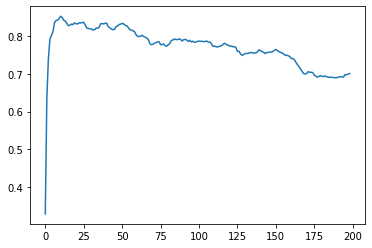

Max at x =  10


In [10]:
X = np.concatenate((X_train, X_test))
Y = np.concatenate((Y_train, Y_test))
train_indices = np.random.choice(X.shape[0], 300, replace=False)
test_indices = np.array([x for x in range(X.shape[0]) if x not in train_indices])
X_train = X[train_indices]
X_test = X[test_indices]
Y_train = Y[train_indices]
Y_test = Y[test_indices]
accuracy_list = []
for x in x_range:
  accuracy_list.append(calAccuracy(x, XY))
plt.plot(accuracy_list)
plt.show()
print("Max at x = ", np.argmax(accuracy_list))

## Game Initialization

In [0]:
mem_size = one_game_steps * 4
batch_size = int(one_game_steps /64) * 64
assert batch_size <= mem_size
random_walk_period = batch_size

accuracy_lookuptb = dict(zip(*(x_range, accuracy_list)))

random_walk_period = batch_size
scaler_state_dtc = MinMaxScaler()
scaler_state_dtc.fit([detect(detect_range, x, accuracy_lookuptb) for x in x_range if np.prod(detect(detect_range, x, accuracy_lookuptb)) > 0])

all_gre = [accuracy_lookuptb[x_range[i]+1] - accuracy_lookuptb[x_range[i]] for i in range(len(x_range)-1)]
all_gre = [x for x in all_gre if x!=0]
scaler_state_gre = MinMaxScaler()
scaler_state_gre.fit(np.array([all_gre,]*len(detect_range)).transpose())

scaler_state_x = MinMaxScaler()
scaler_state_x.fit([[x] for x in x_range])

scaler_state = (scaler_state_dtc, scaler_state_gre, scaler_state_x)

scaler_reward = MinMaxScaler()
scaler_reward.fit([[x] for x in accuracy_list])

init_x = 190
cur_x = init_x
cur_detection = detect(detect_range, init_x, accuracy_lookuptb)
cur_gre = np.zeros(13)

cur_state_dtc = cur_detection
cur_state_gre = cur_gre
cur_state_x = [cur_x]



cur_state, cur_nor_state = norState(cur_state_dtc, cur_state_gre, cur_state_x, scaler_state)

init_state = cur_state
init_nor_state = cur_nor_state

## Make a NN

In [12]:
def makeModel():
  fc1_dims = 200
  fc2_dims = 200
  model = Sequential([
      Dense(fc1_dims, input_shape=(np.array(cur_state).shape[0],)),
      Activation('relu'),
      Dense(fc2_dims),
      Activation('relu'),
      Dense(len(step_options))
  ])


  model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), loss='mse')

  return model

q_model = makeModel()

## Main



  0%|          | 0/10 [00:00<?, ?it/s]

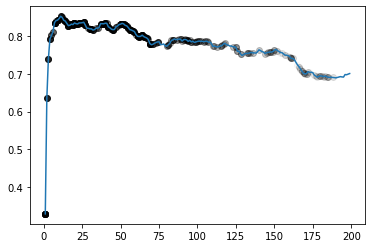



 10%|█         | 1/10 [00:02<00:19,  2.14s/it]

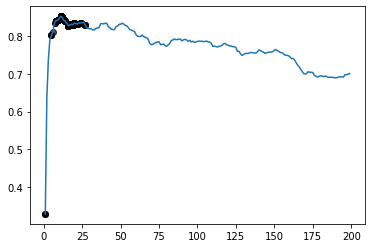



 20%|██        | 2/10 [00:10<00:32,  4.09s/it]

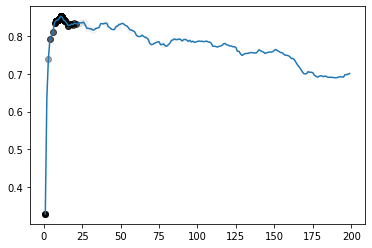



 30%|███       | 3/10 [00:19<00:38,  5.52s/it]

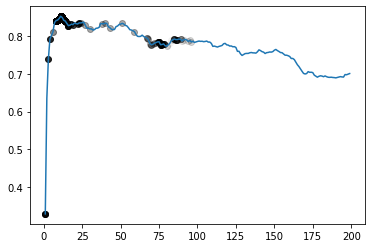



 40%|████      | 4/10 [00:28<00:39,  6.66s/it]

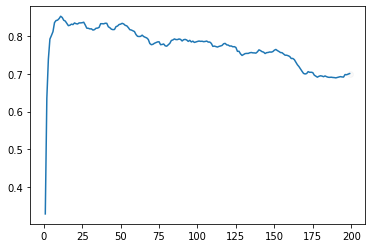



 50%|█████     | 5/10 [00:29<00:23,  4.76s/it]

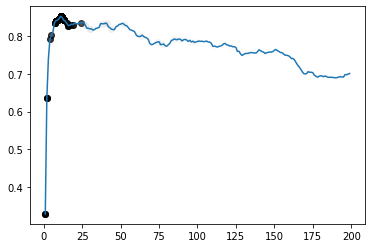



 60%|██████    | 6/10 [00:38<00:24,  6.03s/it]

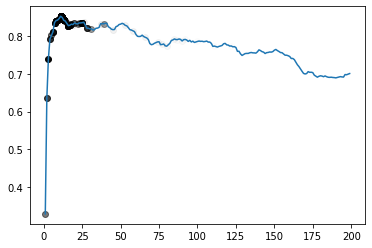



 70%|███████   | 7/10 [00:46<00:20,  6.75s/it]

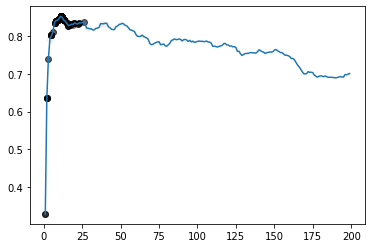



 80%|████████  | 8/10 [00:55<00:14,  7.24s/it]

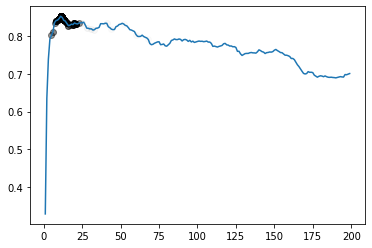



 90%|█████████ | 9/10 [01:04<00:07,  7.83s/it]

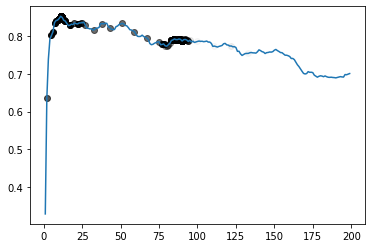



100%|██████████| 10/10 [01:12<00:00,  8.07s/it]



Momentum =  0.3934855859228753


In [0]:
mem_ctr = 0
state_mem = {}
onehot_action_mem = {}
reward_nor_mem = {}
next_state_mem = {}
terminal_mem = {}

reward_nor_his = []

n_games = 10
gamma = 0.5

epsilon = 0.1
epsilon_dec = 0.8

cur_x = init_x

rule_idle = True

idle_range = 0.0002
idle_steps = 5
reward_nor_buffer = []

mom_ind = 0.5
last_mom = np.zeros(len(cur_state_gre))

#use for demonstrate momentum actually happened
action = 0
last_action = 0
momentum_counter = 0
count_momentum = True


for _ in tqdm(range(n_games)):
  cur_x = np.random.choice(x_range[70:])
  for step_ctr in range(one_game_steps):
    
  # predict action
    
    if count_momentum:
      last_action = action

    if mem_ctr < random_walk_period or np.random.uniform() <= epsilon:
      action = np.random.choice(step_options)
    else:
      # once random walk were done, the state in memory will be normalized

      indices = np.random.choice(len(state_mem), batch_size, replace=False)

      batch_states = np.array(list(state_mem.values()))[indices]
      batch_next_states = np.array(list(next_state_mem.values()))[indices]
      batch_actions = np.array(list(onehot_action_mem.values()))[indices]
      batch_rewards = np.array(list(reward_nor_mem.values()))[indices]
      q_matrix = q_model.predict(batch_states)
      q_next = q_model.predict(batch_next_states)

      actions_indices = np.dot(batch_actions, np.arange(len(step_options), dtype=np.int64))
      batch_indices = np.arange(batch_size, dtype=np.int64)

      q_matrix[batch_indices, actions_indices] = batch_rewards + gamma*np.max(q_next, axis=1)


      q_model.fit(batch_states, q_matrix, verbose=0, epochs = 1)

      action = step_options[np.argmax(q_model.predict(cur_nor_state.reshape(1, len(cur_state))))]
    
    if action == 0:
      action = np.random.choice([1, -1])

    
    if count_momentum and last_action * action >0:
      momentum_counter += 1

    next_state, next_nor_state, next_x, reward = step(cur_state, action, cur_x, scaler_state, accuracy_lookuptb)

    reward_nor = scaler_reward.transform([[reward]])[0][0]

    if rule_idle:
      try:
        reward_nor_buffer[mem_ctr%idle_steps] = reward_nor
        if mem_ctr >= random_walk_period and max(reward_nor_buffer) - min(reward_nor_buffer) < idle_range:
          break
      except:
        reward_nor_buffer.append(reward_nor)
    
    writeMem(cur_nor_state, next_nor_state, action, reward_nor)

    # print("cur_state = %s, cur_x = %s, action = %s, reward = %s"%(str(cur_state), str(cur_x), str(action), str(reward)))
    # print(reward_nor_buffer, max(reward_nor_buffer)- min(reward_nor_buffer))
    reward_nor_his.append(reward_nor)

    cur_state = next_state
    cur_nor_state = next_nor_state
    cur_x = next_x

    mem_ctr += 1

    plt.scatter(cur_x, reward, alpha=max(step_ctr/ one_game_steps, 0.1), c='black')

  plt.plot(x_range, accuracy_list)
  plt.show()

if count_momentum:
  print("Momentum = ", momentum_counter/mem_ctr)

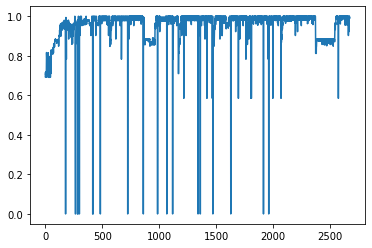

In [0]:
plt.plot(reward_nor_his)

## Single Agent: Train on Different Maps




  0%|          | 0/10 [00:00<?, ?it/s]

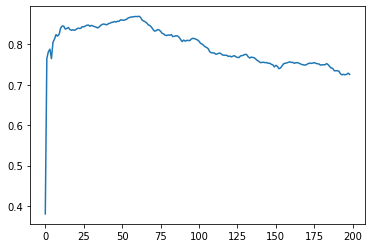

Max at x =  61


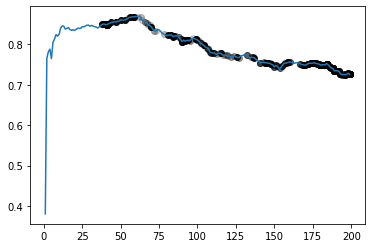

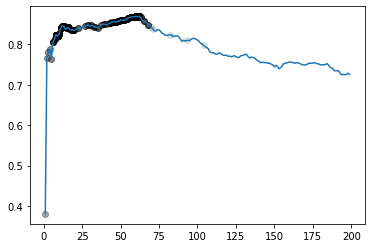

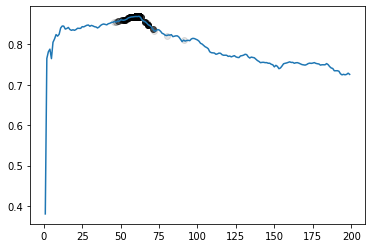

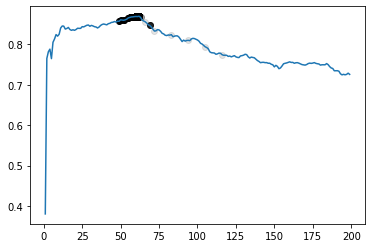

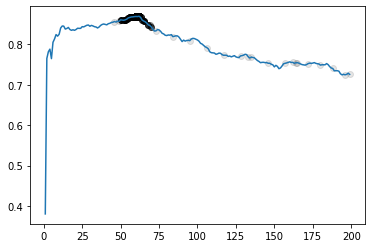

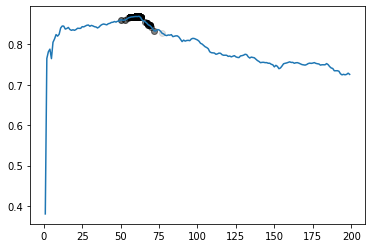

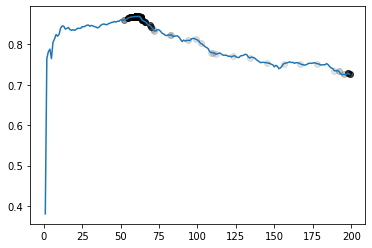

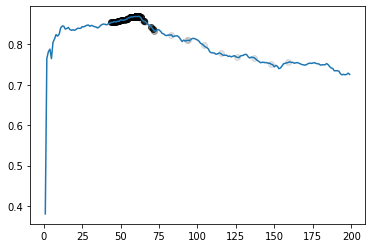

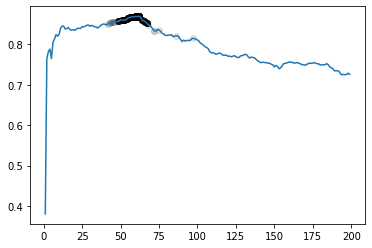

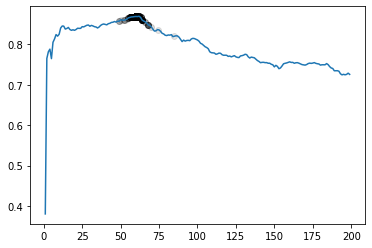




 10%|█         | 1/10 [01:38<14:42, 98.01s/it]

Momentum =  0.294


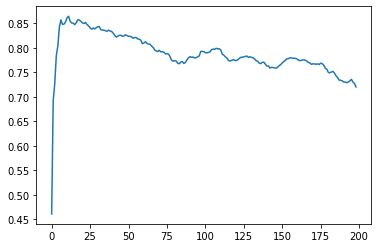

Max at x =  11


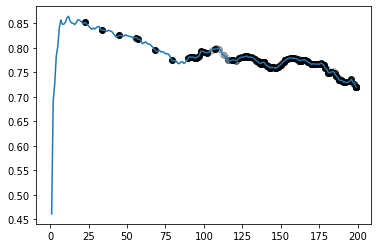

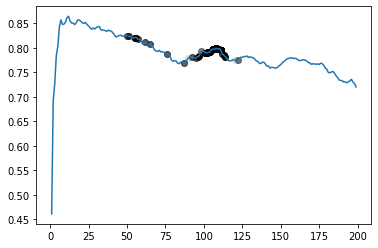

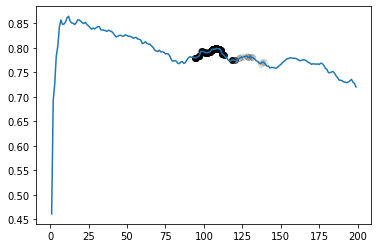

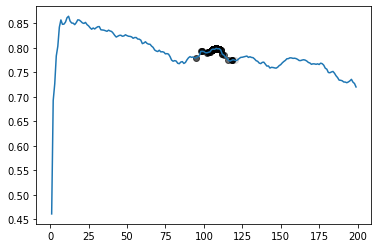

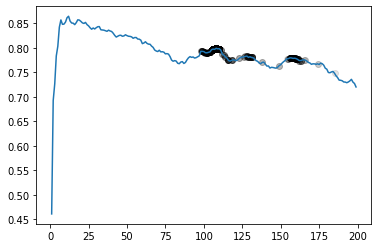

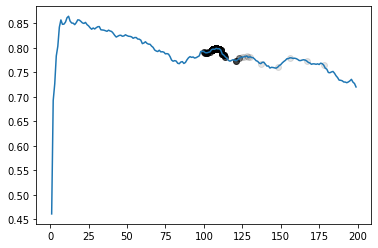

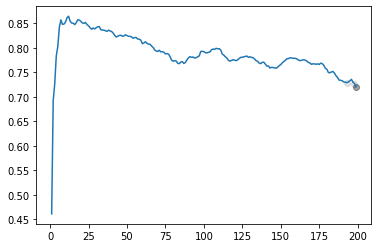

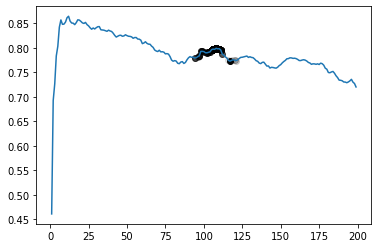

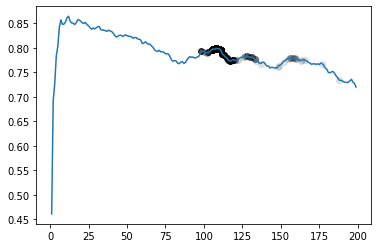

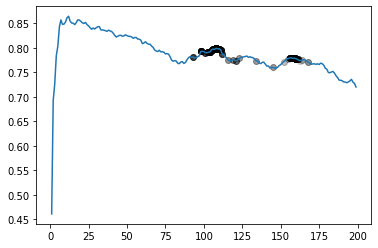




 20%|██        | 2/10 [03:04<12:35, 94.41s/it]

Momentum =  0.4716039907904835


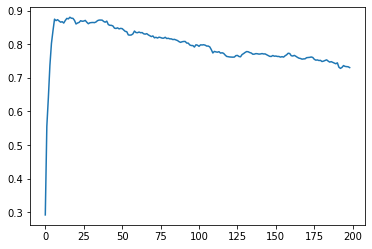

Max at x =  16


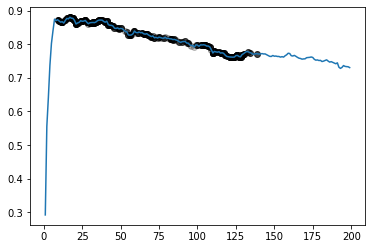

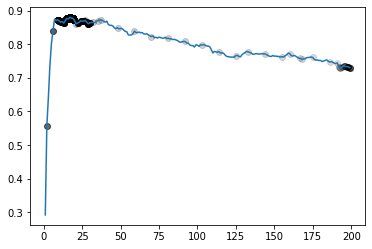

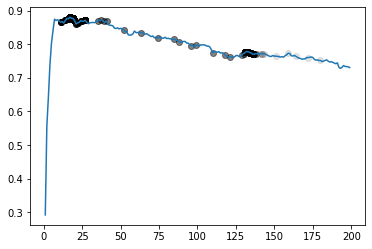

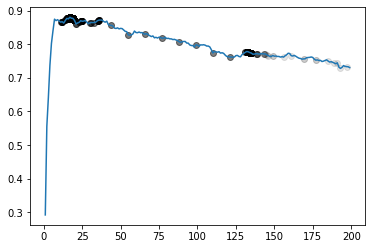

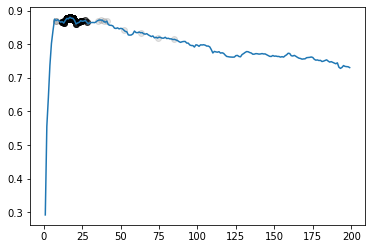

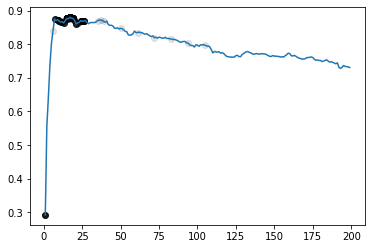

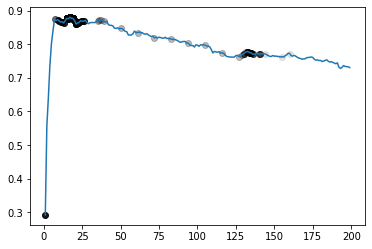

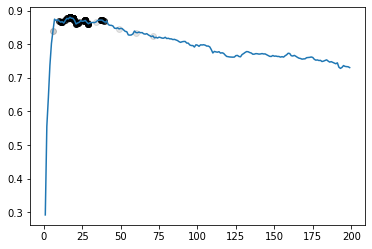

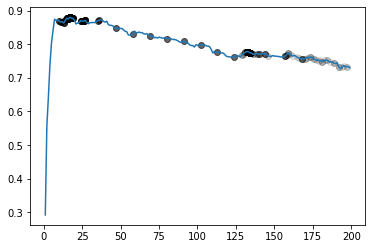

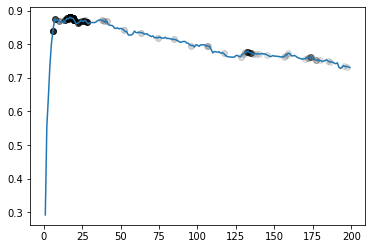




 30%|███       | 3/10 [04:40<11:04, 94.99s/it]

Momentum =  0.3433333333333333


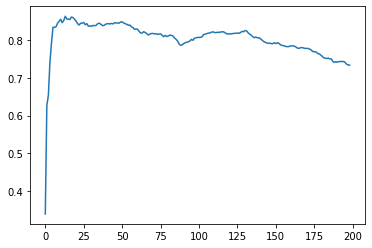

Max at x =  13


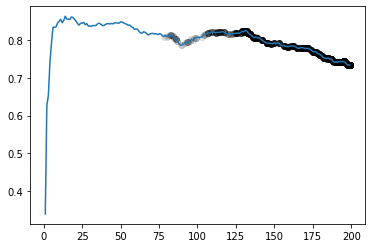

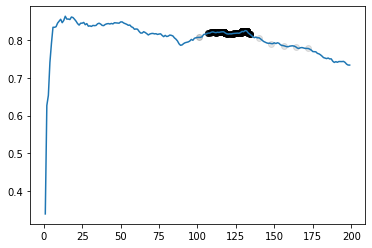

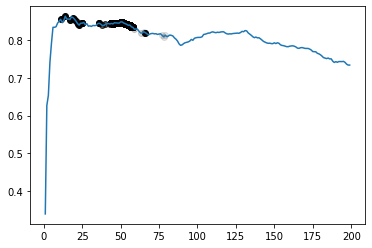

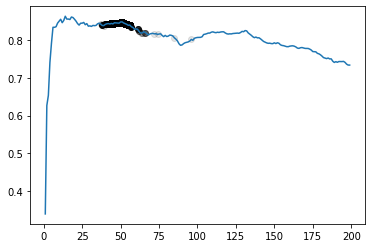

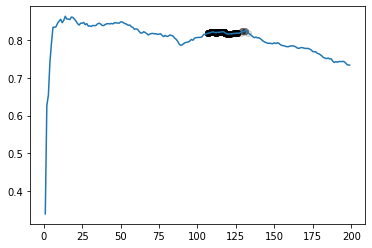

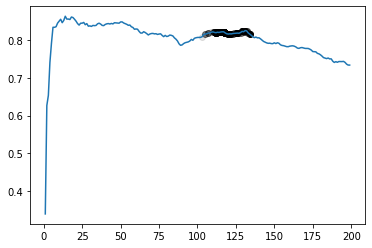

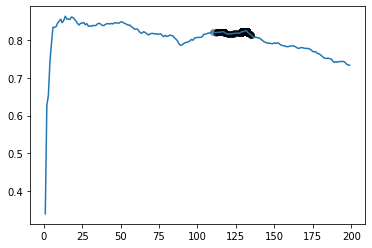

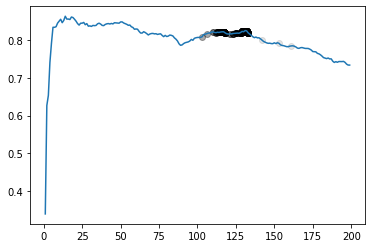

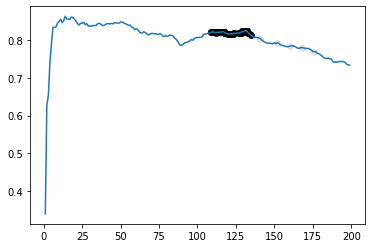

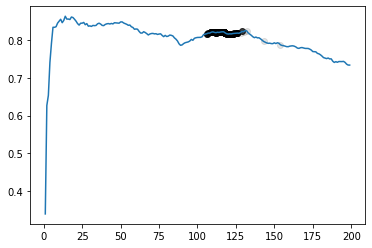




 40%|████      | 4/10 [06:17<09:32, 95.49s/it]

Momentum =  0.39566666666666667


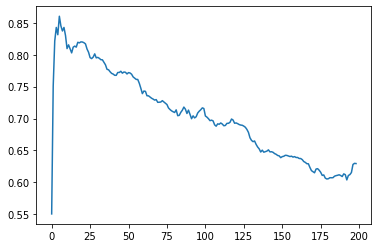

Max at x =  5


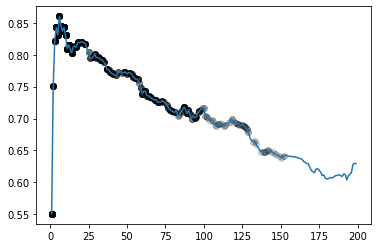

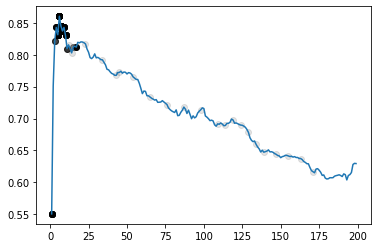

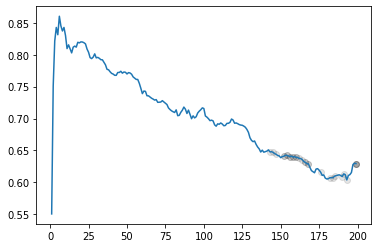

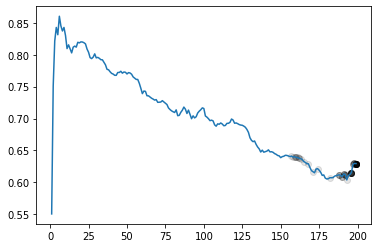

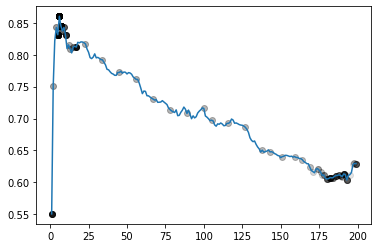

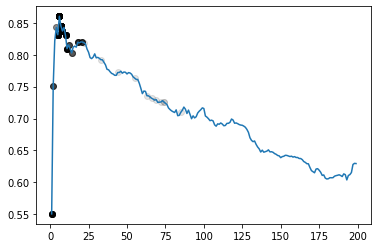

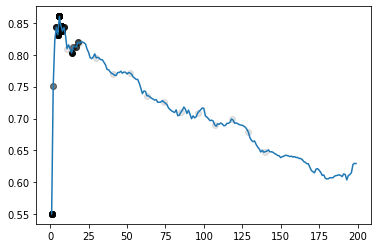

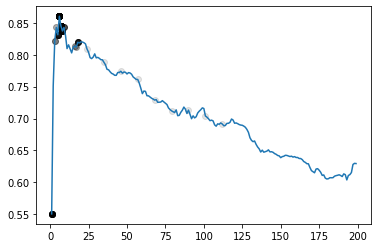

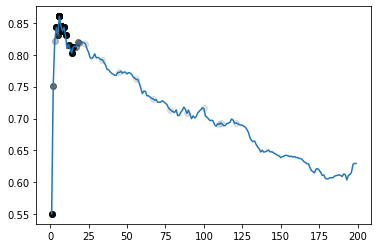

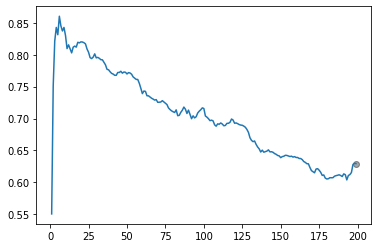




 50%|█████     | 5/10 [07:28<07:21, 88.31s/it]

Momentum =  0.24863387978142076


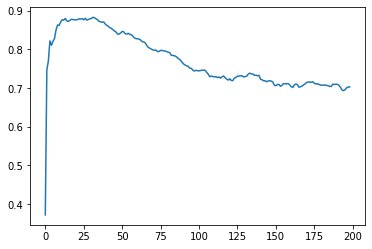

Max at x =  31


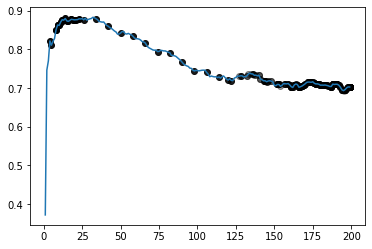

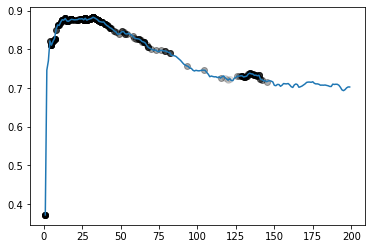

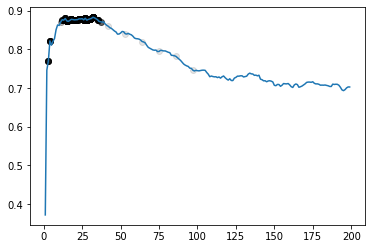

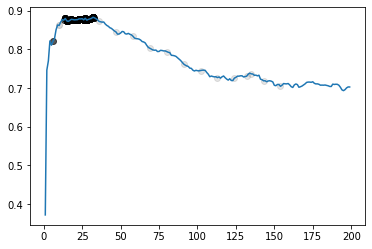

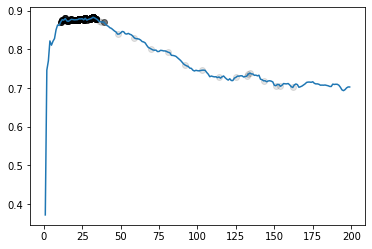

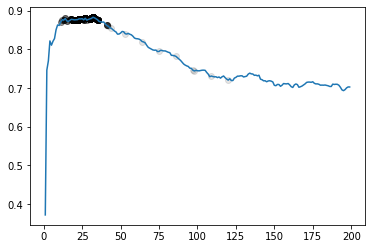

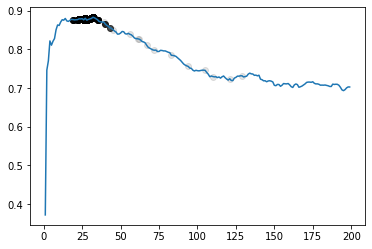

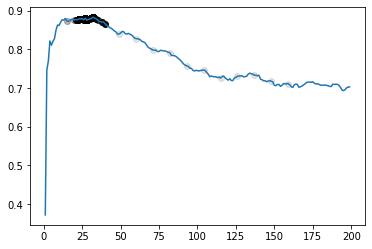

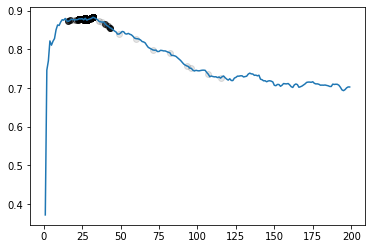

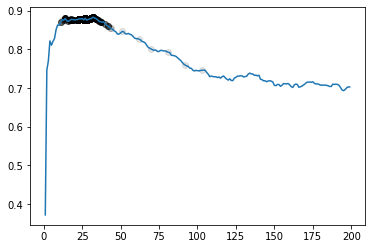




 60%|██████    | 6/10 [09:02<05:59, 89.92s/it]

Momentum =  0.366


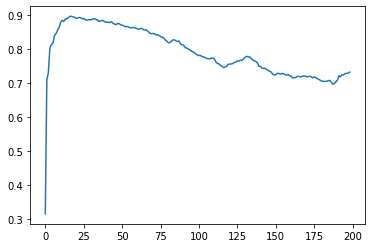

Max at x =  17


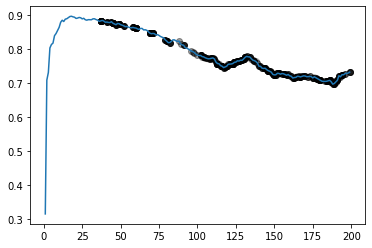

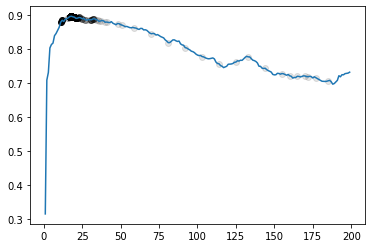

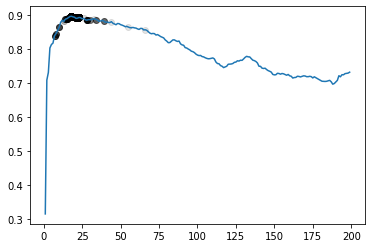

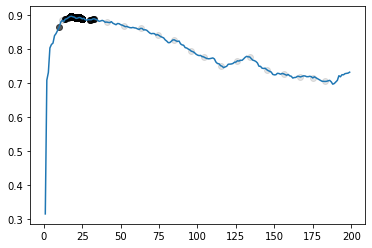

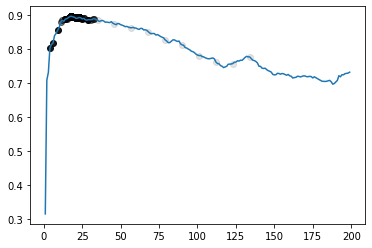

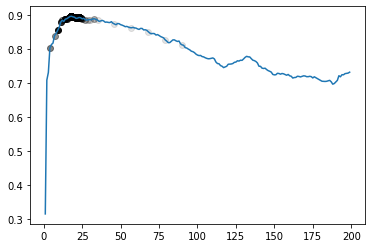

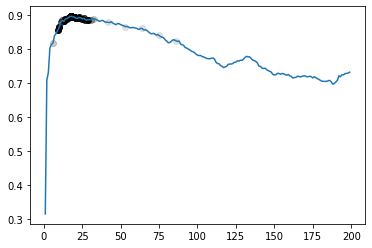

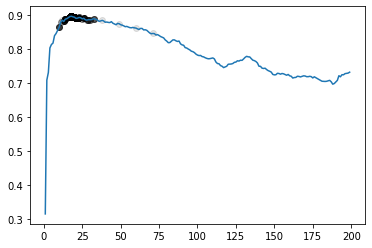

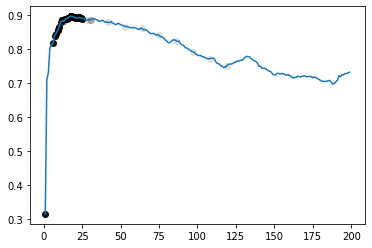

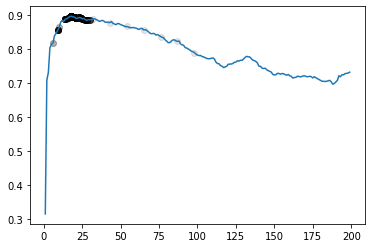




 70%|███████   | 7/10 [10:34<04:31, 90.61s/it]

Momentum =  0.406


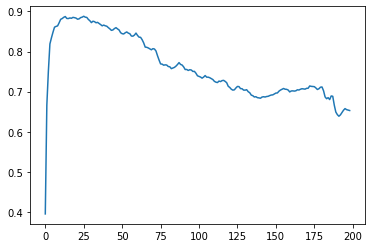

Max at x =  25


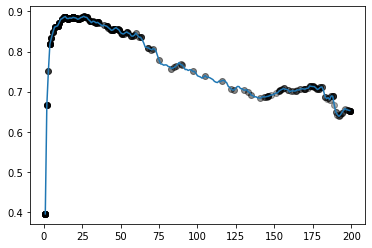

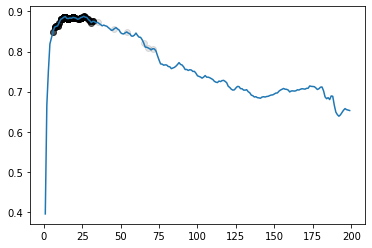

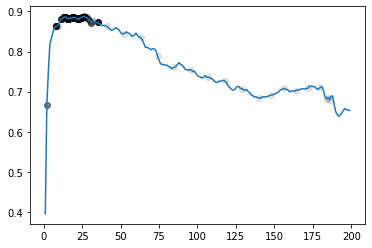

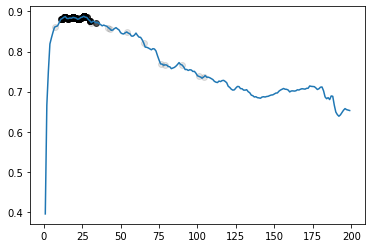

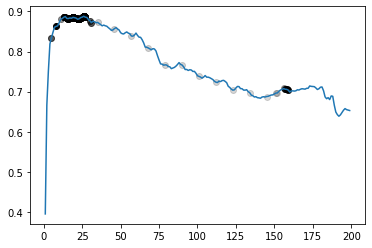

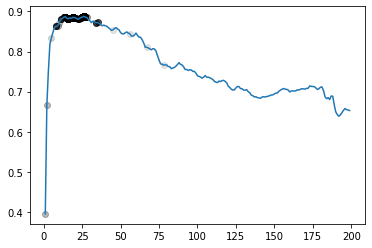

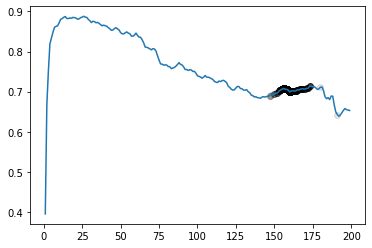

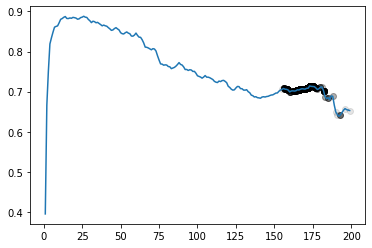

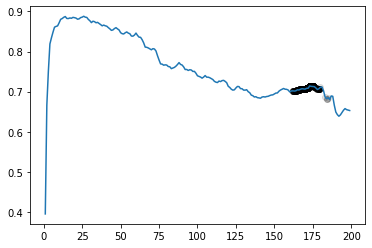

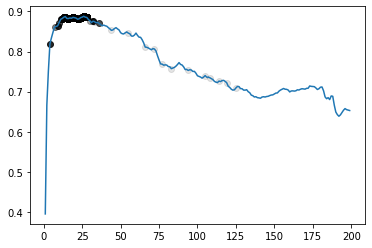




 80%|████████  | 8/10 [12:07<03:02, 91.29s/it]

Momentum =  0.38166666666666665


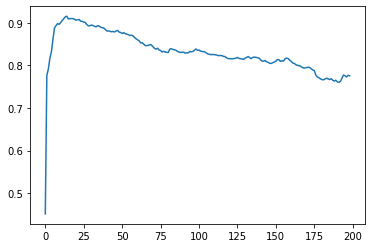

Max at x =  14


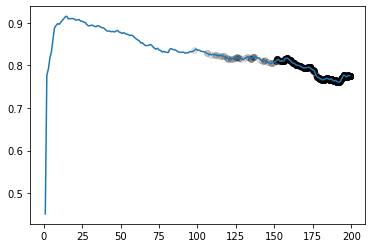

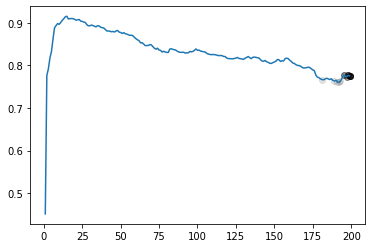

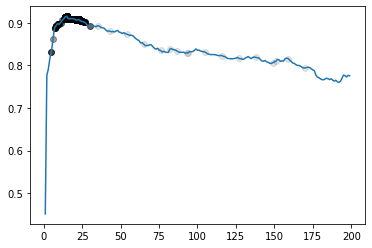

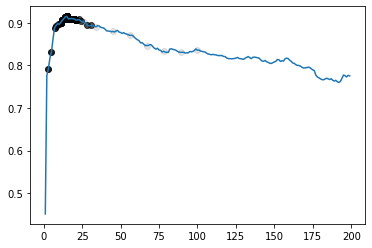

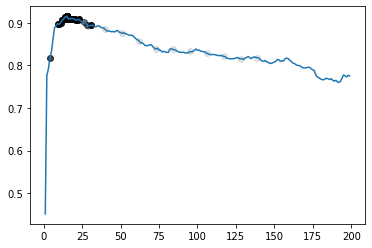

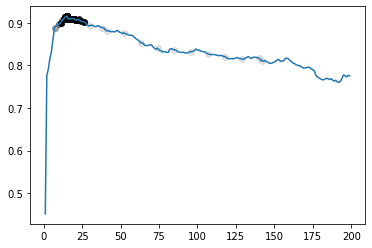

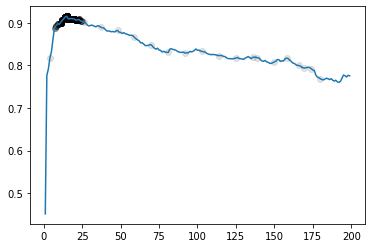

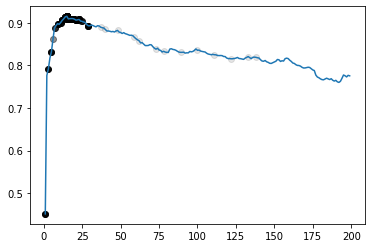

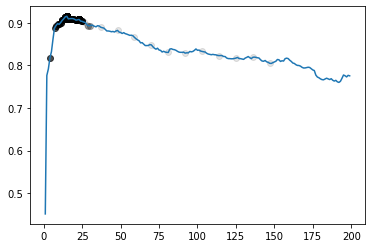

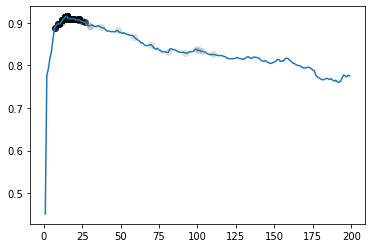




 90%|█████████ | 9/10 [13:31<01:29, 89.13s/it]

Momentum =  0.30387143900657415


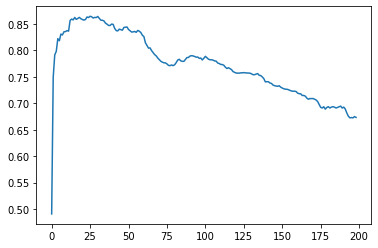

Max at x =  25


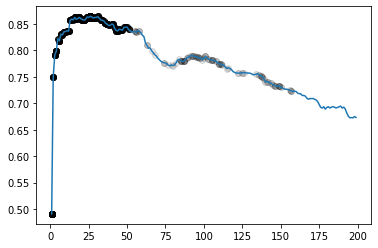

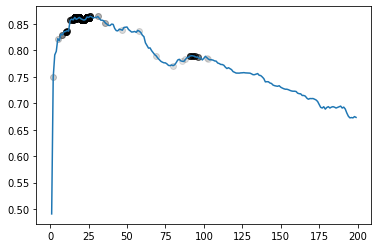

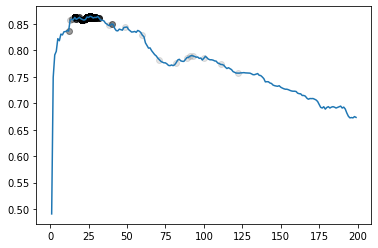

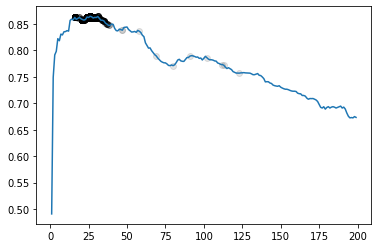

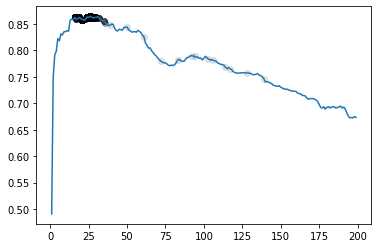

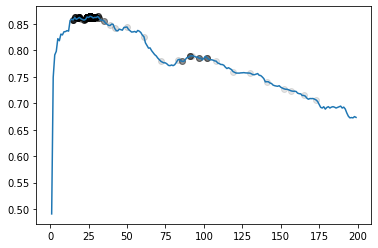

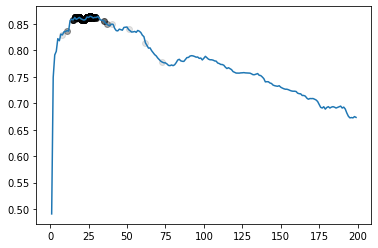

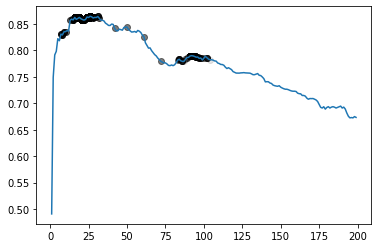

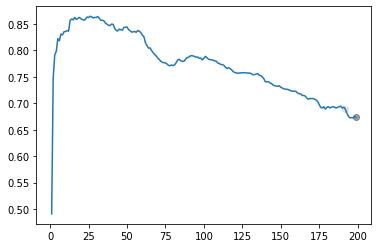

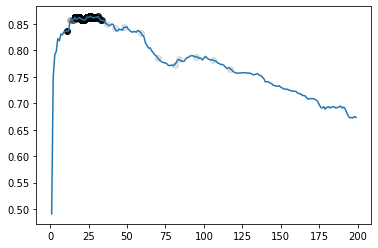




100%|██████████| 10/10 [14:57<00:00, 88.17s/it]




Momentum =  0.41072088724584105


In [0]:
n_trains = 10
for _ in tqdm(range(n_trains)):
  X = np.concatenate((X_train, X_test))
  Y = np.concatenate((Y_train, Y_test))
  train_indices = np.random.choice(X.shape[0], 300, replace=False)
  test_indices = np.array([x for x in range(X.shape[0]) if x not in train_indices])
  X_train = X[train_indices]
  X_test = X[test_indices]
  Y_train = Y[train_indices]
  Y_test = Y[test_indices]
  XY = (X_train, X_test, Y_train, Y_test)
  accuracy_list = []
  for x in x_range:
    accuracy_list.append(calAccuracy(x, XY))
  plt.plot(accuracy_list)
  plt.show()
  print("Max at x = ", np.argmax(accuracy_list))

  mem_size = one_game_steps * 4
  batch_size = int(one_game_steps /64) * 64
  assert batch_size <= mem_size
  random_walk_period = batch_size

  accuracy_lookuptb = dict(zip(*(x_range, accuracy_list)))

  random_walk_period = batch_size
  scaler_state_dtc = MinMaxScaler()
  scaler_state_dtc.fit([detect(detect_range, x, accuracy_lookuptb) for x in x_range if np.prod(detect(detect_range, x, accuracy_lookuptb)) > 0])

  all_gre = [accuracy_lookuptb[x_range[i]+1] - accuracy_lookuptb[x_range[i]] for i in range(len(x_range)-1)]
  all_gre = [x for x in all_gre if x!=0]
  scaler_state_gre = MinMaxScaler()
  scaler_state_gre.fit(np.array([all_gre,]*len(detect_range)).transpose())

  scaler_state_x = MinMaxScaler()
  scaler_state_x.fit([[x] for x in x_range])

  scaler_state = (scaler_state_dtc, scaler_state_gre, scaler_state_x)

  scaler_reward = MinMaxScaler()
  scaler_reward.fit([[x] for x in accuracy_list])

  init_x = 190
  cur_x = init_x
  cur_detection = detect(detect_range, init_x, accuracy_lookuptb)
  cur_gre = np.zeros(13)

  cur_state_dtc = cur_detection
  cur_state_gre = cur_gre
  cur_state_x = [cur_x]



  cur_state, cur_nor_state = norState(cur_state_dtc, cur_state_gre, cur_state_x, scaler_state)

  init_state = cur_state
  init_nor_state = cur_nor_state


  mem_ctr = 0
  state_mem = {}
  onehot_action_mem = {}
  reward_nor_mem = {}
  next_state_mem = {}
  terminal_mem = {}

  reward_nor_his = []

  n_games = 10
  gamma = 0.5

  epsilon = 0.1
  epsilon_dec = 0.8

  cur_x = init_x

  rule_idle = True

  idle_range = 0.0002
  idle_steps = 5
  reward_nor_buffer = []

  mom_ind = 0.5
  last_mom = np.zeros(len(cur_state_gre))

  #use for demonstrate momentum actually happened
  action = 0
  last_action = 0
  momentum_counter = 0
  count_momentum = True


  for _ in range(n_games):
    cur_x = np.random.choice(x_range[70:])
    for step_ctr in range(one_game_steps):
      
    # predict action
      
      if count_momentum:
        last_action = action

      if mem_ctr < random_walk_period or np.random.uniform() <= epsilon:
        action = np.random.choice(step_options)
      else:
        # once random walk were done, the state in memory will be normalized

        indices = np.random.choice(len(state_mem), batch_size, replace=False)

        batch_states = np.array(list(state_mem.values()))[indices]
        batch_next_states = np.array(list(next_state_mem.values()))[indices]
        batch_actions = np.array(list(onehot_action_mem.values()))[indices]
        batch_rewards = np.array(list(reward_nor_mem.values()))[indices]
        q_matrix = q_model.predict(batch_states)
        q_next = q_model.predict(batch_next_states)

        actions_indices = np.dot(batch_actions, np.arange(len(step_options), dtype=np.int64))
        batch_indices = np.arange(batch_size, dtype=np.int64)

        q_matrix[batch_indices, actions_indices] = batch_rewards + gamma*np.max(q_next, axis=1)


        q_model.fit(batch_states, q_matrix, verbose=0, epochs = 1)

        action = step_options[np.argmax(q_model.predict(cur_nor_state.reshape(1, len(cur_state))))]
      
      if action == 0:
        action = np.random.choice([1, -1])

      
      if count_momentum and last_action * action >0:
        momentum_counter += 1

      next_state, next_nor_state, next_x, reward = step(cur_state, action, cur_x, scaler_state, accuracy_lookuptb)

      reward_nor = scaler_reward.transform([[reward]])[0][0]

      if rule_idle:
        try:
          reward_nor_buffer[mem_ctr%idle_steps] = reward_nor
          if mem_ctr >= random_walk_period and max(reward_nor_buffer) - min(reward_nor_buffer) < idle_range:
            break
        except:
          reward_nor_buffer.append(reward_nor)
      
      writeMem(cur_nor_state, next_nor_state, action, reward_nor)

      # print("cur_state = %s, cur_x = %s, action = %s, reward = %s"%(str(cur_state), str(cur_x), str(action), str(reward)))
      # print(reward_nor_buffer, max(reward_nor_buffer)- min(reward_nor_buffer))
      reward_nor_his.append(reward_nor)

      cur_state = next_state
      cur_nor_state = next_nor_state
      cur_x = next_x

      mem_ctr += 1

      plt.scatter(cur_x, reward, alpha=max(step_ctr/ one_game_steps, 0.1), c='black')

    plt.plot(x_range, accuracy_list)
    plt.show()

  if count_momentum:
    print("Momentum = ", momentum_counter/mem_ctr)

## Single Agent: Test on Different Map




  0%|          | 0/10 [00:00<?, ?it/s]

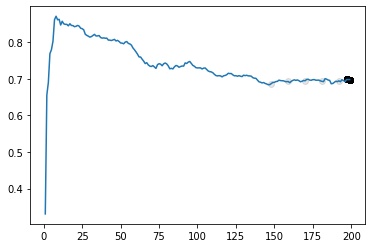




 10%|█         | 1/10 [00:14<02:06, 14.03s/it]

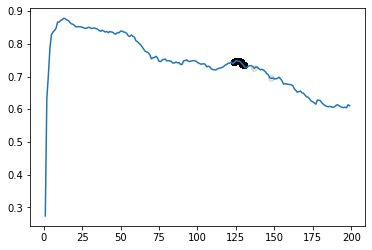




 20%|██        | 2/10 [00:28<01:52, 14.02s/it]

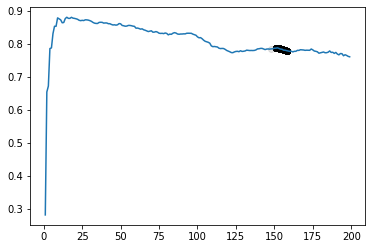




 30%|███       | 3/10 [00:41<01:37, 13.99s/it]

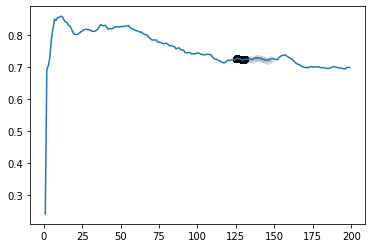




 40%|████      | 4/10 [00:56<01:24, 14.09s/it]

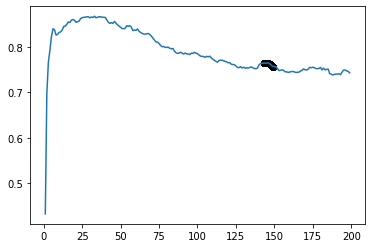




 50%|█████     | 5/10 [01:10<01:10, 14.02s/it]

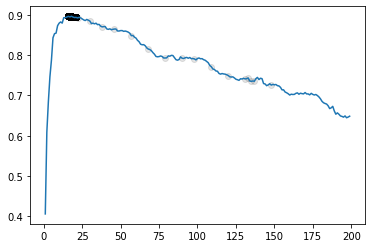




 60%|██████    | 6/10 [01:23<00:55, 13.95s/it]

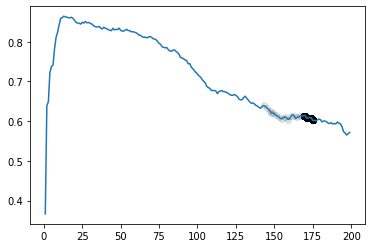




 70%|███████   | 7/10 [01:37<00:41, 13.99s/it]

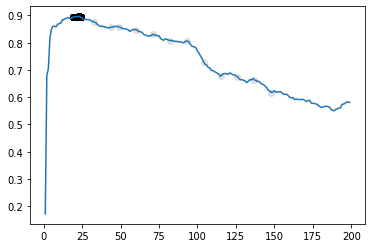




 80%|████████  | 8/10 [01:51<00:27, 13.98s/it]

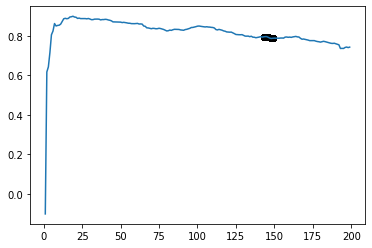




 90%|█████████ | 9/10 [02:05<00:13, 13.98s/it]

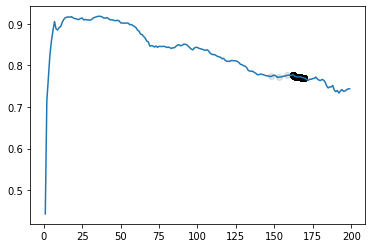




100%|██████████| 10/10 [02:20<00:00, 14.02s/it]




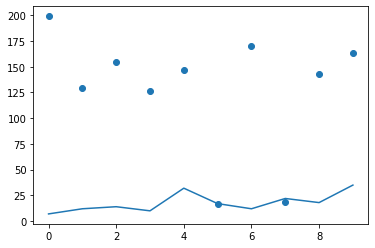

In [0]:
max_x_list = []
past_max_x_list = []

n_tests = 10

for _ in tqdm(range(n_tests)):
  X = np.concatenate((X_train, X_test))
  Y = np.concatenate((Y_train, Y_test))
  train_indices = np.random.choice(X.shape[0], 300, replace=False)
  test_indices = np.array([x for x in range(X.shape[0]) if x not in train_indices])
  X_train_test = X[train_indices]
  X_test_test = X[test_indices]
  Y_train_test = Y[train_indices]
  Y_test_test = Y[test_indices]
  accuracy_list_test = []
  accuracy_lookuptb_test = {}
  for x in x_range:
    # accuracy_list_test.append(calAccuracyTest(x))
    accuracy_list_test.append(calAccuracyTest(x))
    accuracy_lookuptb_test[x] = accuracy_list_test[-1]
  max_x_list.append(np.argmax(accuracy_list_test))
  
  next_x_test = -1
  cur_x_test = 140

  cur_detection_test = detect(detect_range, cur_x_test, accuracy_lookuptb_test)
  cur_gre_test = np.zeros(13)

  cur_state_dtc_test = cur_detection
  cur_state_gre_test = cur_gre
  cur_state_x_test = [cur_x_test]
  cur_state_test, cur_nor_state_test = norState(cur_state_dtc_test, cur_state_gre_test, cur_state_x_test, scaler_state)

  init_state_test = cur_state_test
  init_nor_state_test = cur_nor_state_test
  max_state_test = cur_state_test

  for step_ctr in range(180):
    action_test = step_options[np.argmax(q_model.predict(cur_nor_state_test.reshape(1, len(cur_state))))]

    next_state_test, next_nor_state_test, next_x_test, reward_test = step(cur_state_test, action_test, cur_x_test, scaler_state, accuracy_lookuptb_test)

    reward_nor_test = scaler_reward.transform([[reward_test]])[0][0]

    if reward_test > max_state_test[3]:
      max_state_test = next_state_test

    reward_nor_his.append(reward_nor)

    cur_state_test = next_state_test
    cur_nor_state_test = next_nor_state_test
    cur_x_test = next_x_test
    plt.scatter(cur_x_test, reward_test, alpha=max(step_ctr/ one_game_steps, 0.1), c='black')

  plt.plot(x_range, accuracy_list_test)
  plt.show()
  past_max_x_list.append(cur_x_test)


plt.plot(range(n_tests), max_x_list)
plt.scatter(range(n_tests), past_max_x_list)

## Multi Agent: Train on Different Maps

### Set up Agents

In [0]:
n_agents = 10
agents = []
for _ in range(n_agents):
  agents.append(makeModel())

0it [00:00, ?it/s]

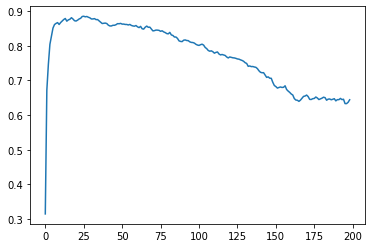

Max at x =  25










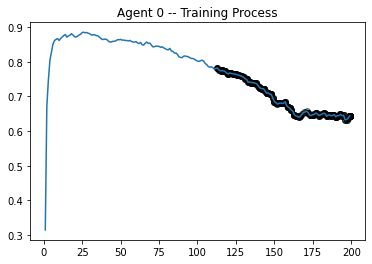

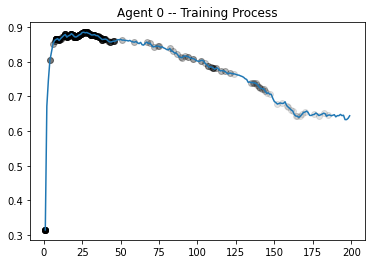

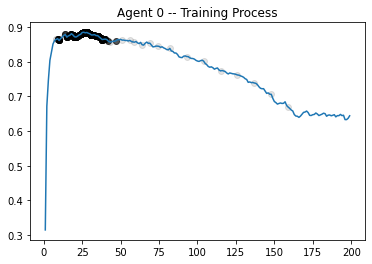

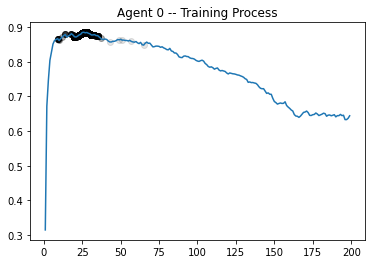

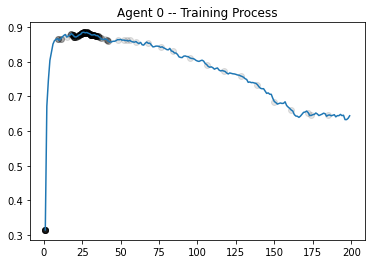

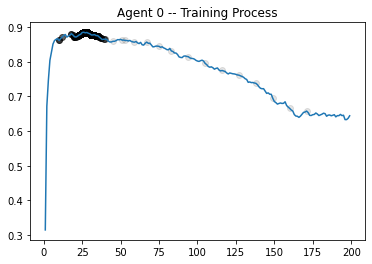

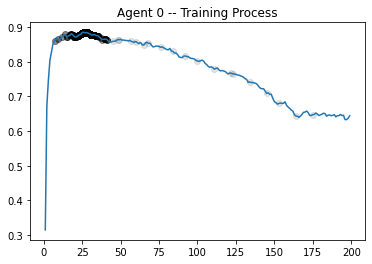

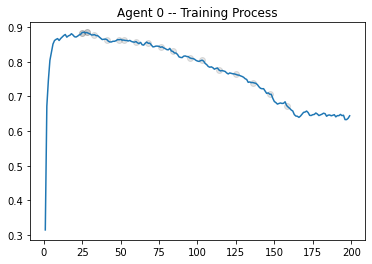

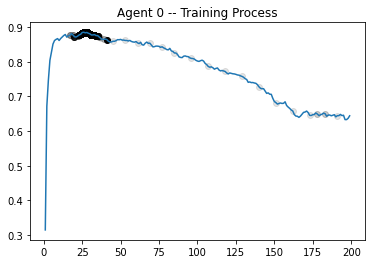

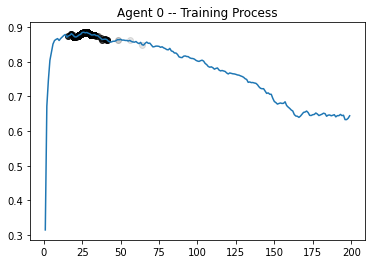

1it [01:13, 73.12s/it]

Momentum =  0.5430194805194806


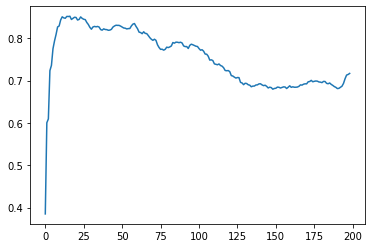

Max at x =  16


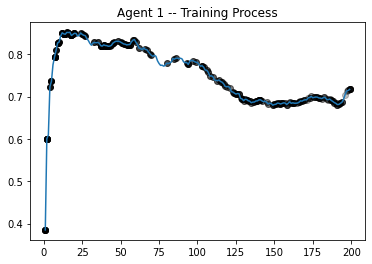

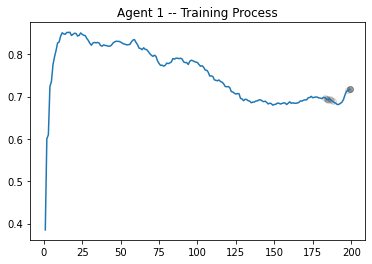

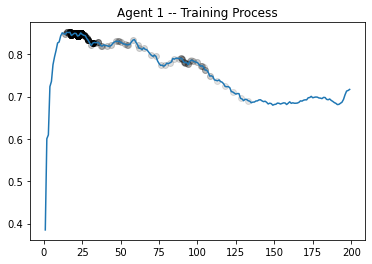

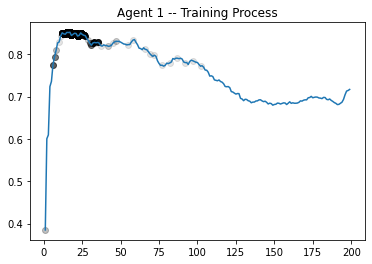

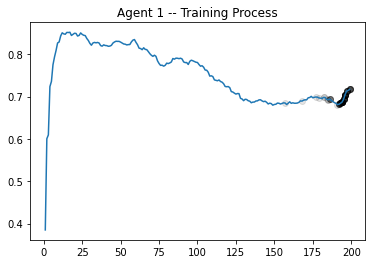

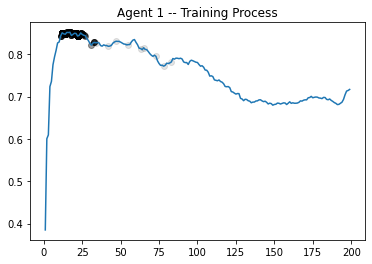

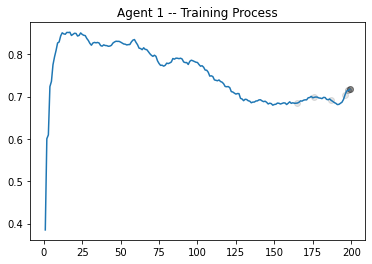

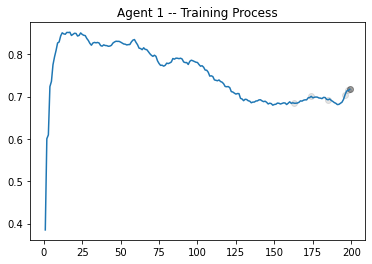

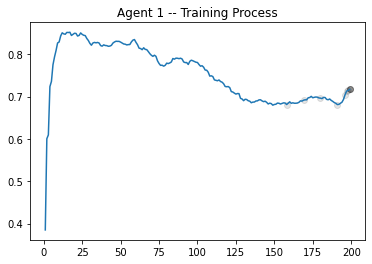

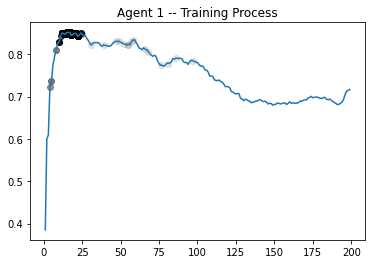

2it [02:03, 66.29s/it]

Momentum =  0.3608374384236453


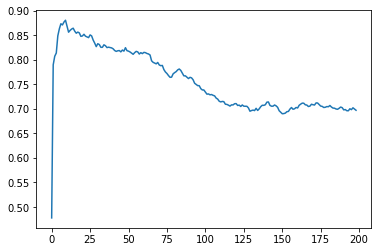

Max at x =  9


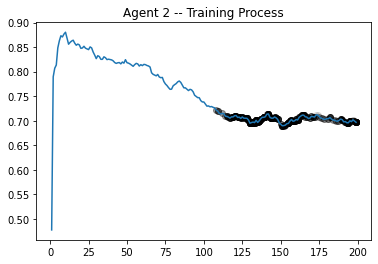

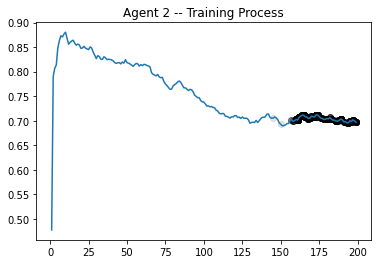

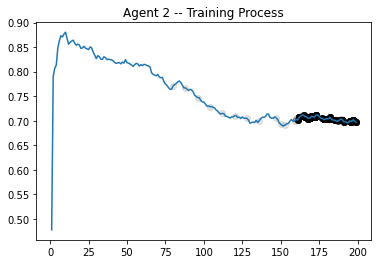

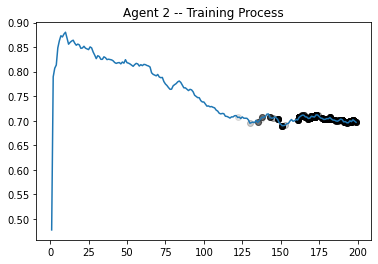

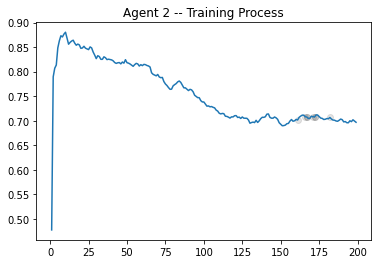

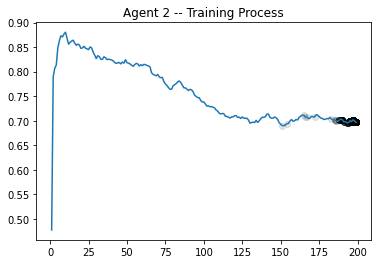

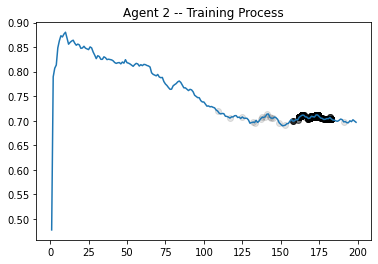

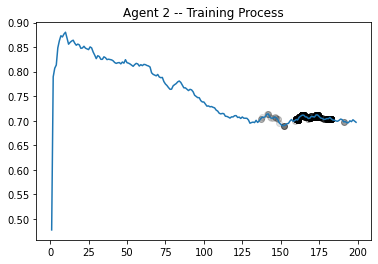

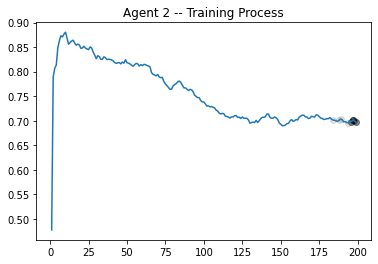

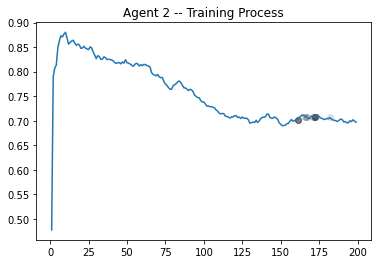

3it [03:05, 64.90s/it]

Momentum =  0.31212121212121213


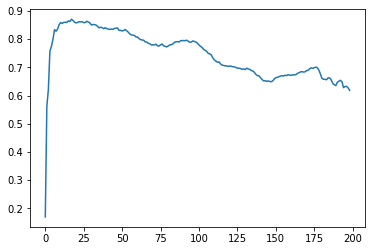

Max at x =  17


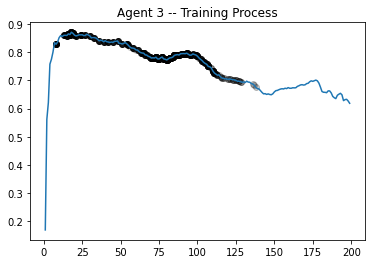

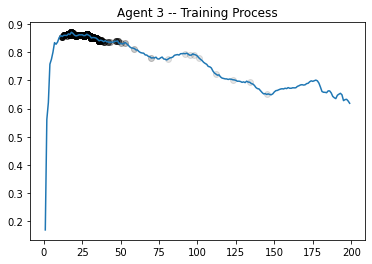

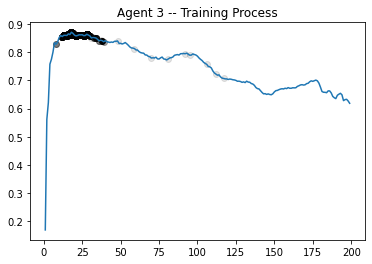

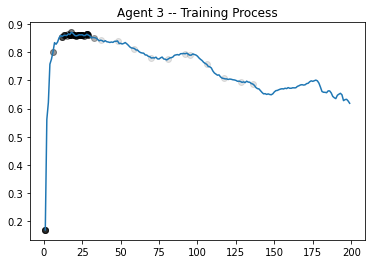

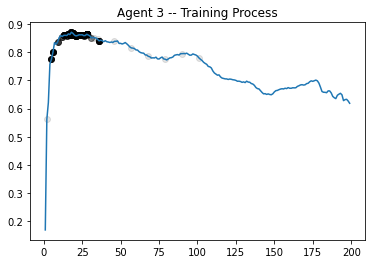

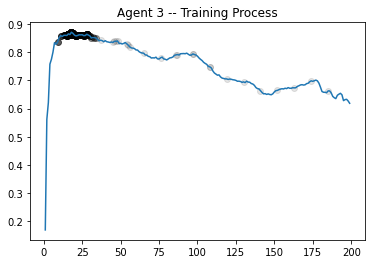

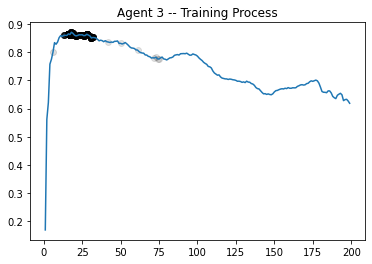

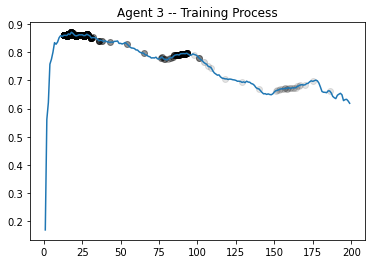

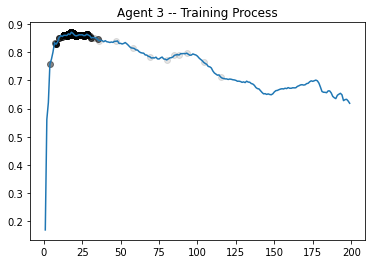

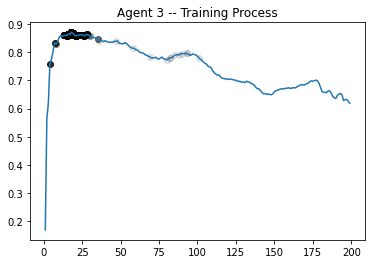

4it [04:29, 70.62s/it]

Momentum =  0.3920940170940171


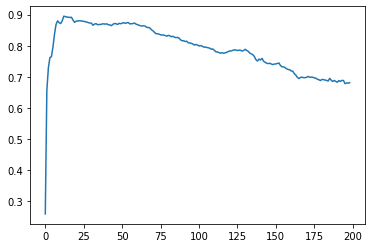

Max at x =  12


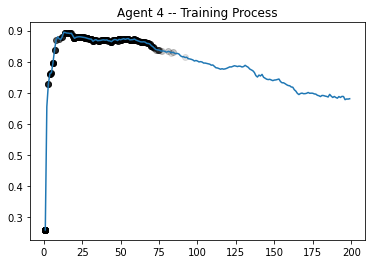

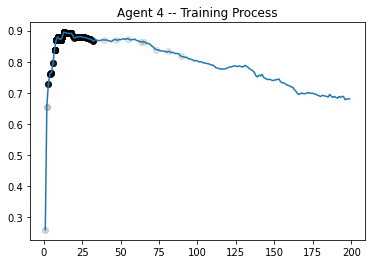

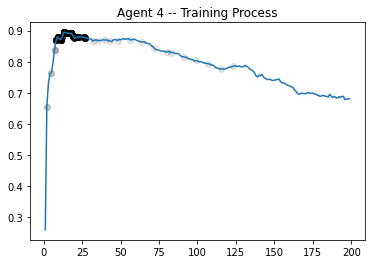

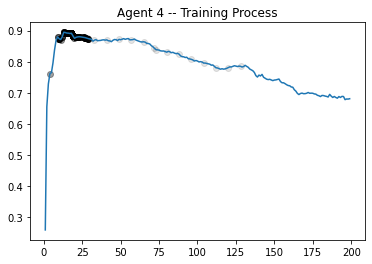

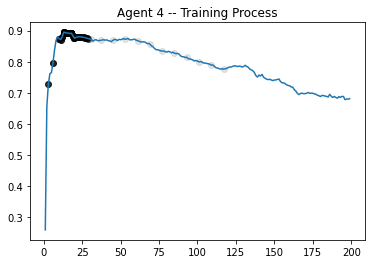

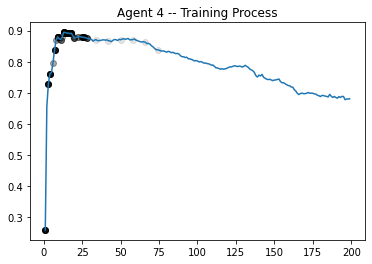

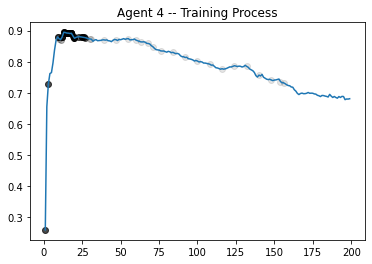

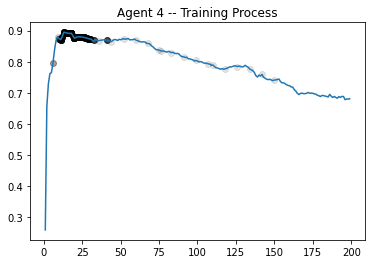

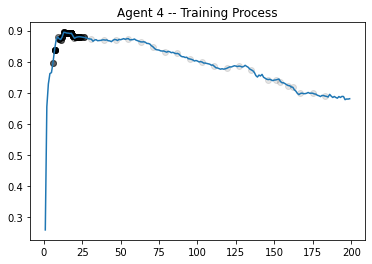

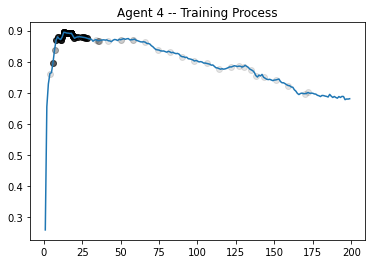

5it [05:58, 76.33s/it]

Momentum =  0.34611503531786075


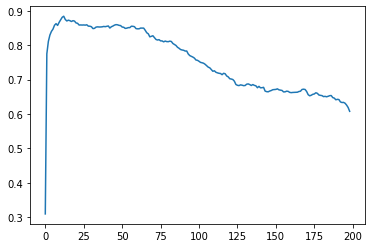

Max at x =  12


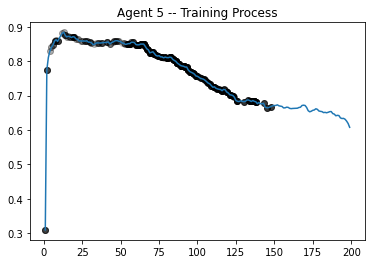

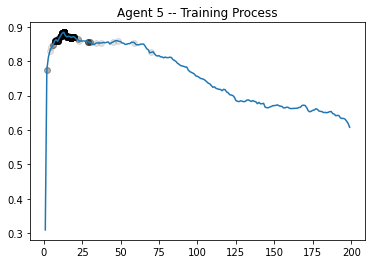

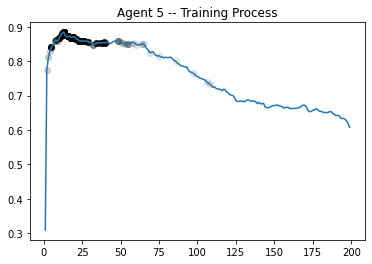

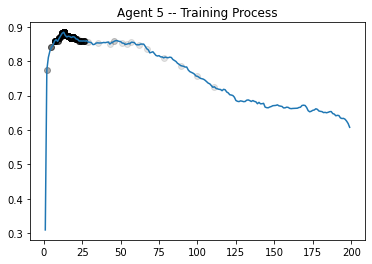

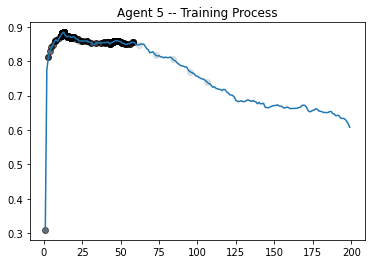

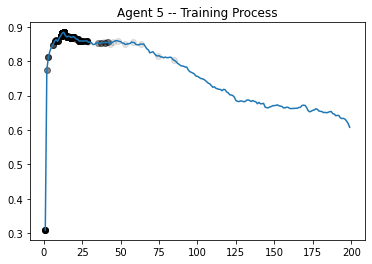

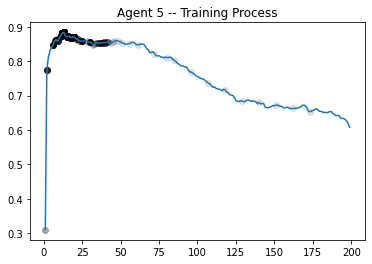

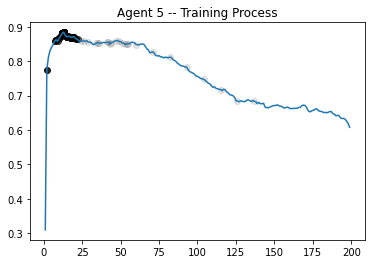

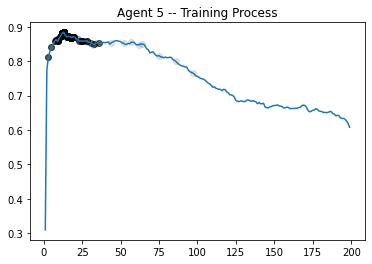

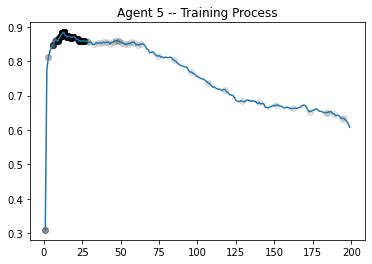

6it [07:24, 79.10s/it]

Momentum =  0.2824427480916031


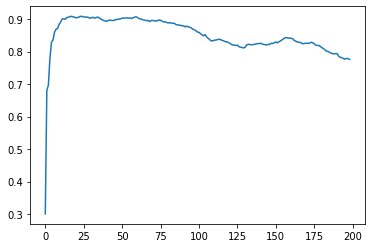

Max at x =  23


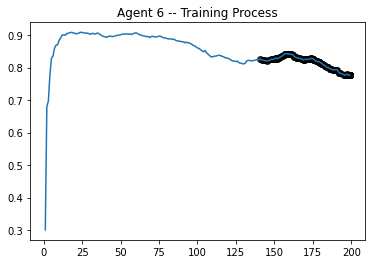

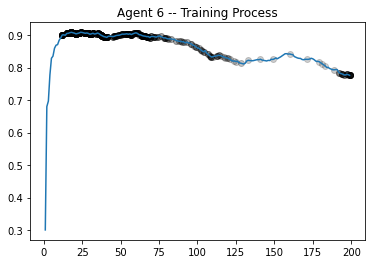

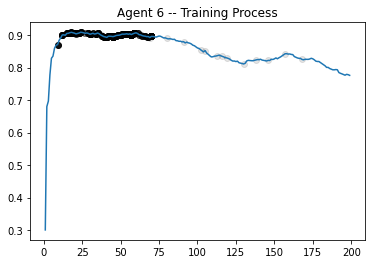

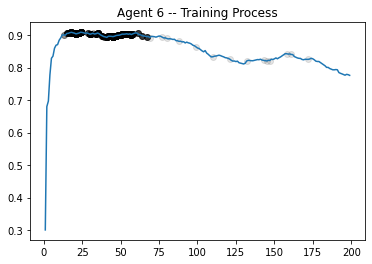

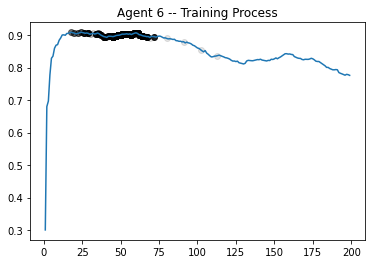

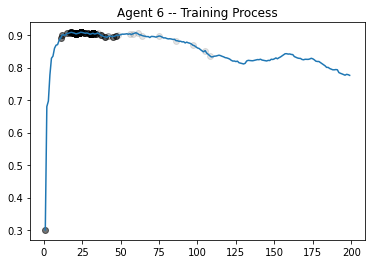

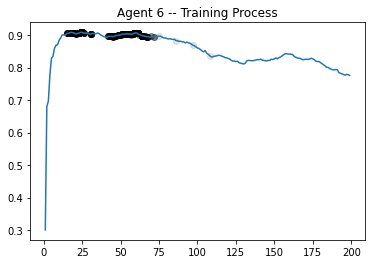

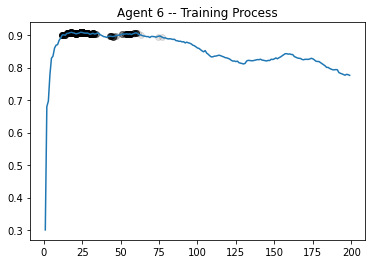

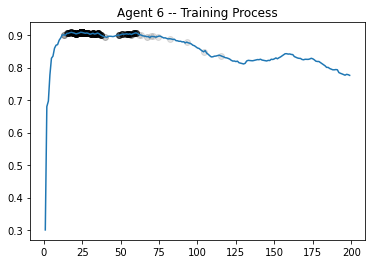

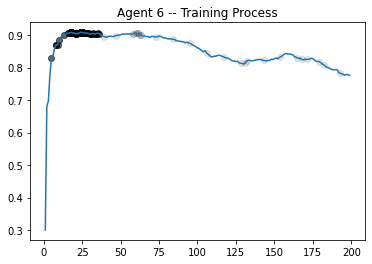

7it [08:53, 82.24s/it]

Momentum =  0.4937563280458994


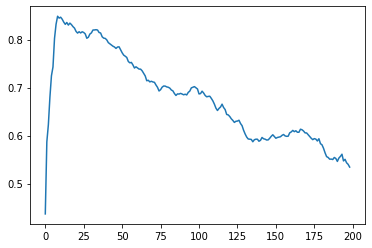

Max at x =  8


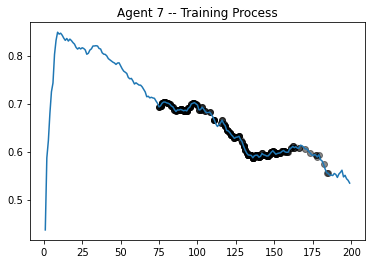

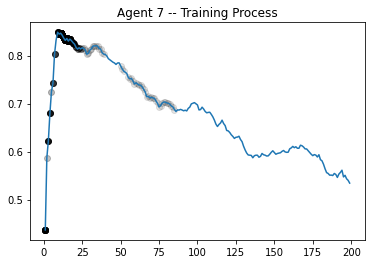

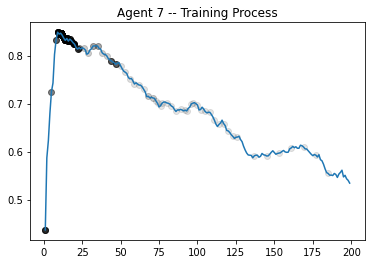

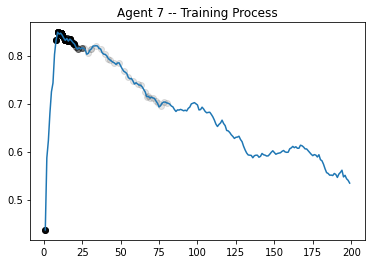

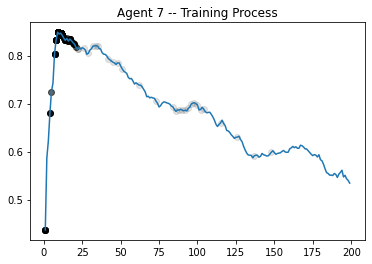

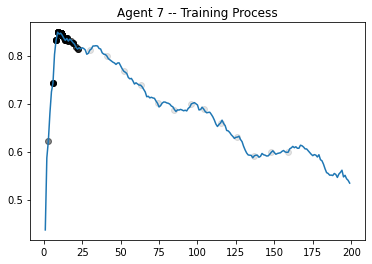

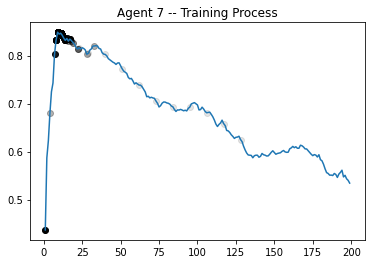

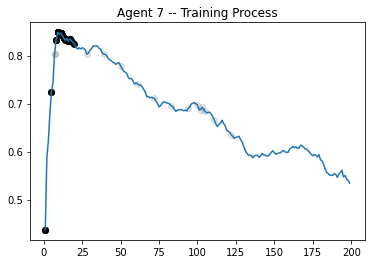

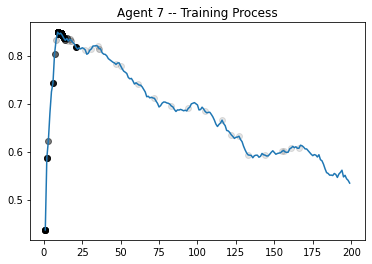

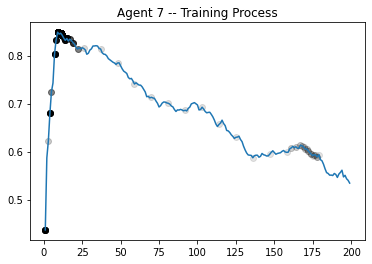

8it [10:25, 85.06s/it]

Momentum =  0.36966666666666664


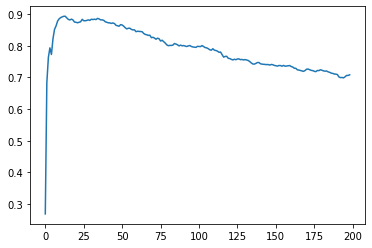

Max at x =  13


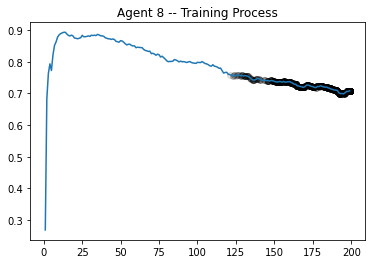

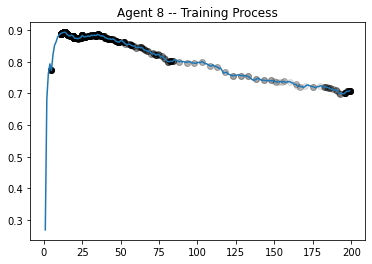

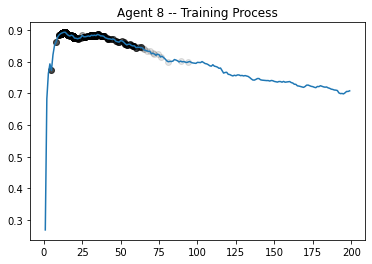

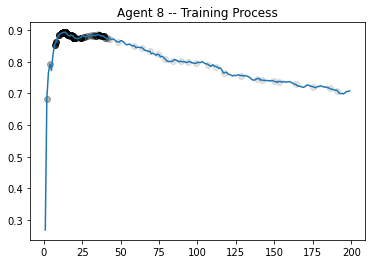

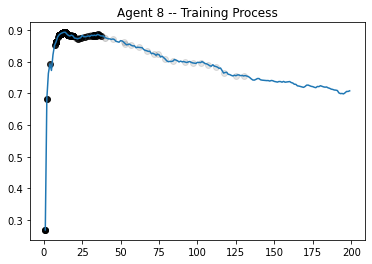

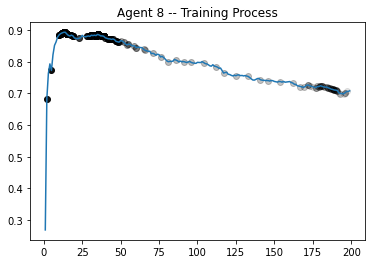

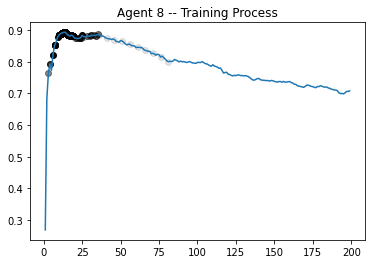

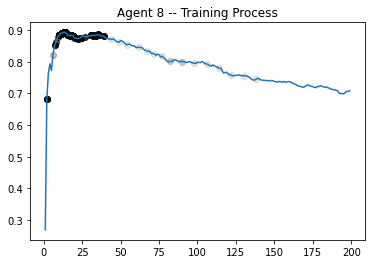

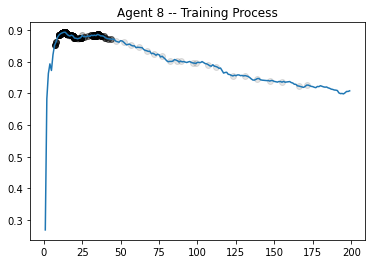

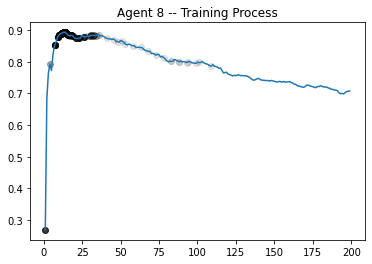

9it [11:54, 86.24s/it]

Momentum =  0.41459314055144586


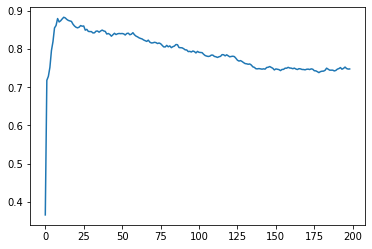

Max at x =  12


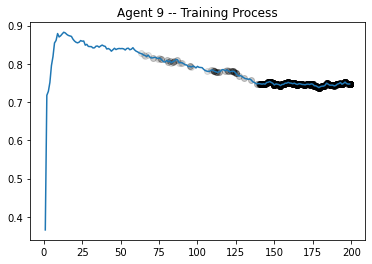

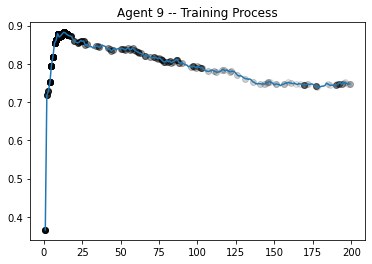

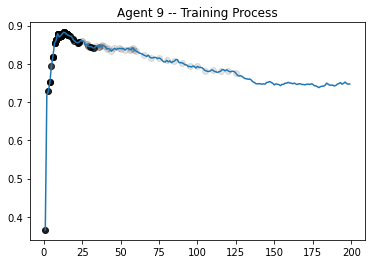

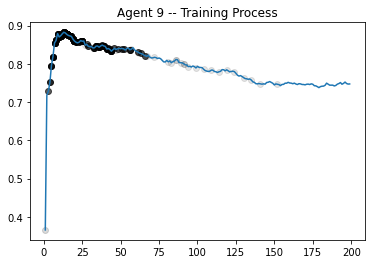

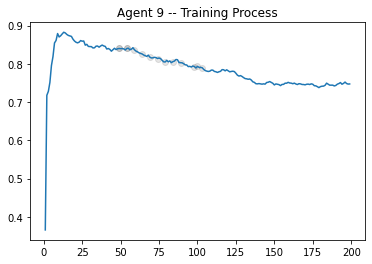

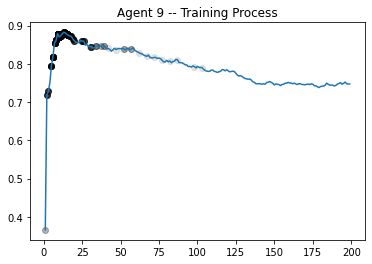

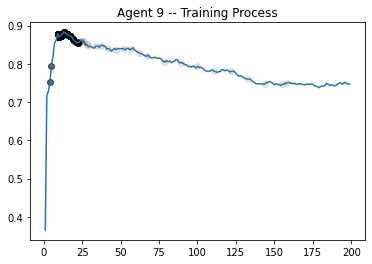

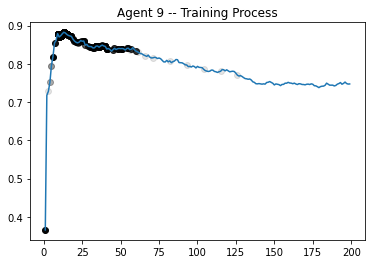

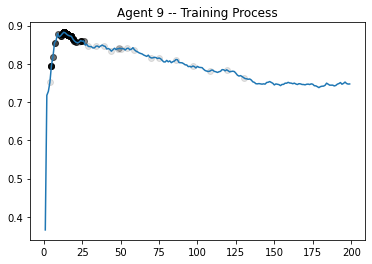

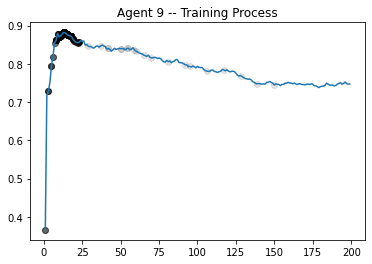

10it [13:14, 84.43s/it]

Momentum =  0.393515106853353


In [14]:
verbose = 0

for i, q_model in tqdm(enumerate(agents)):
  ## make a new map
  X = np.concatenate((X_train, X_test))
  Y = np.concatenate((Y_train, Y_test))
  train_indices = np.random.choice(X.shape[0], 300, replace=False)
  test_indices = np.array([x for x in range(X.shape[0]) if x not in train_indices])
  X_train = X[train_indices]
  X_test = X[test_indices]
  Y_train = Y[train_indices]
  Y_test = Y[test_indices]
  XY = (X_train, X_test, Y_train, Y_test)
  accuracy_list = []
  for x in x_range:
    accuracy_list.append(calAccuracy(x, XY))
  if verbose:
    plt.plot(accuracy_list)
    plt.show()
  print("Max at x = ", np.argmax(accuracy_list))

  mem_size = one_game_steps * 4
  batch_size = int(one_game_steps /64) * 64
  assert batch_size <= mem_size
  random_walk_period = batch_size

  accuracy_lookuptb = dict(zip(*(x_range, accuracy_list)))

  random_walk_period = batch_size

  ## cal the init state
  scaler_state_dtc = MinMaxScaler()
  scaler_state_dtc.fit([detect(detect_range, x, accuracy_lookuptb) for x in x_range if np.prod(detect(detect_range, x, accuracy_lookuptb)) > 0])

  all_gre = [accuracy_lookuptb[x_range[i]+1] - accuracy_lookuptb[x_range[i]] for i in range(len(x_range)-1)]
  all_gre = [x for x in all_gre if x!=0]
  scaler_state_gre = MinMaxScaler()
  scaler_state_gre.fit(np.array([all_gre,]*len(detect_range)).transpose())

  scaler_state_x = MinMaxScaler()
  scaler_state_x.fit([[x] for x in x_range])

  scaler_state = (scaler_state_dtc, scaler_state_gre, scaler_state_x)

  scaler_reward = MinMaxScaler()
  scaler_reward.fit([[x] for x in accuracy_list])

  init_x = 190
  cur_x = init_x
  cur_detection = detect(detect_range, init_x, accuracy_lookuptb)
  cur_gre = np.zeros(13)

  cur_state_dtc = cur_detection
  cur_state_gre = cur_gre
  cur_state_x = [cur_x]



  cur_state, cur_nor_state = norState(cur_state_dtc, cur_state_gre, cur_state_x, scaler_state)

  init_state = cur_state
  init_nor_state = cur_nor_state

## init memoeries and policies
  mem_ctr = 0
  state_mem = {}
  onehot_action_mem = {}
  reward_nor_mem = {}
  next_state_mem = {}
  terminal_mem = {}

  reward_nor_his = []

  n_games = 10
  gamma = 0.5

  epsilon = 0.1
  epsilon_dec = 0.8

  cur_x = init_x

  rule_idle = True

  idle_range = 0.0002
  idle_steps = 5
  reward_nor_buffer = []

  mom_ind = 0.5
  last_mom = np.zeros(len(cur_state_gre))

  #use for demonstrate momentum actually happened
  action = 0
  last_action = 0
  momentum_counter = 0
  count_momentum = True

## start training
  for _ in range(n_games):
    cur_x = np.random.choice(x_range[70:])
    for step_ctr in range(one_game_steps):
      
    # predict action
      
      if count_momentum:
        last_action = action

      if mem_ctr < random_walk_period or np.random.uniform() <= epsilon:
        action = np.random.choice(step_options)
      else:
        # once random walk were done, the state in memory will be normalized

        indices = np.random.choice(len(state_mem), batch_size, replace=False)

        batch_states = np.array(list(state_mem.values()))[indices]
        batch_next_states = np.array(list(next_state_mem.values()))[indices]
        batch_actions = np.array(list(onehot_action_mem.values()))[indices]
        batch_rewards = np.array(list(reward_nor_mem.values()))[indices]
        q_matrix = q_model.predict(batch_states)
        q_next = q_model.predict(batch_next_states)

        actions_indices = np.dot(batch_actions, np.arange(len(step_options), dtype=np.int64))
        batch_indices = np.arange(batch_size, dtype=np.int64)

        q_matrix[batch_indices, actions_indices] = batch_rewards + gamma*np.max(q_next, axis=1)


        q_model.fit(batch_states, q_matrix, verbose=0, epochs = 1)

        action = step_options[np.argmax(q_model.predict(cur_nor_state.reshape(1, len(cur_state))))]
      
      if action == 0:
        action = np.random.choice([1, -1])

      
      if count_momentum and last_action * action >0:
        momentum_counter += 1

      next_state, next_nor_state, next_x, reward = step(cur_state, action, cur_x, scaler_state, accuracy_lookuptb)

      reward_nor = scaler_reward.transform([[reward]])[0][0]

      if rule_idle:
        try:
          reward_nor_buffer[mem_ctr%idle_steps] = reward_nor
          if mem_ctr >= random_walk_period and max(reward_nor_buffer) - min(reward_nor_buffer) < idle_range:
            break
        except:
          reward_nor_buffer.append(reward_nor)
      
      writeMem(cur_nor_state, next_nor_state, action, reward_nor)

      # print("cur_state = %s, cur_x = %s, action = %s, reward = %s"%(str(cur_state), str(cur_x), str(action), str(reward)))
      # print(reward_nor_buffer, max(reward_nor_buffer)- min(reward_nor_buffer))
      reward_nor_his.append(reward_nor)

      cur_state = next_state
      cur_nor_state = next_nor_state
      cur_x = next_x

      mem_ctr += 1
      
      if verbose:
        plt.scatter(cur_x, reward, alpha=max(step_ctr/ one_game_steps, 0.1), c='black')

    if verbose:
      plt.plot(x_range, accuracy_list)
      plt.title("Agent %d -- Training Process"%i)
      plt.show()

  if count_momentum:
    print("Momentum = ", momentum_counter/mem_ctr)

  agents[i] = q_model

## Multi Agent: Test on Different Maps

  0%|          | 0/20 [00:00<?, ?it/s]

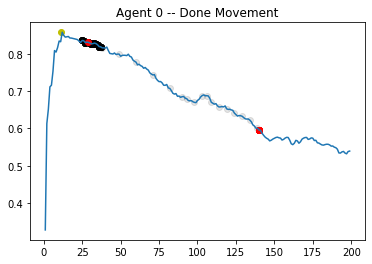

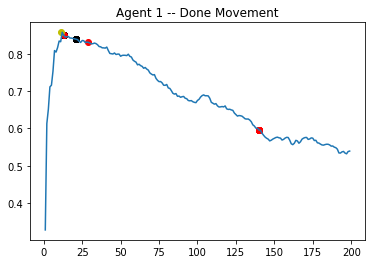

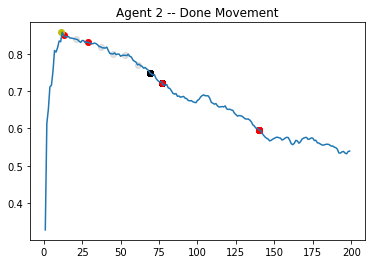

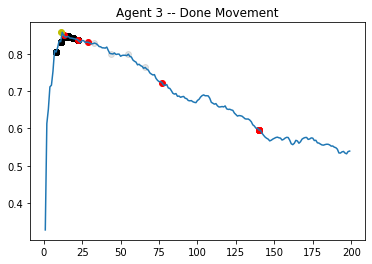

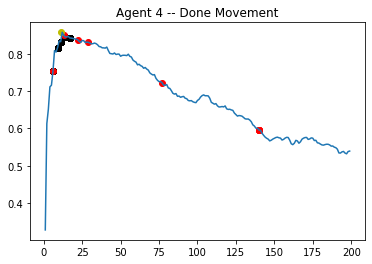

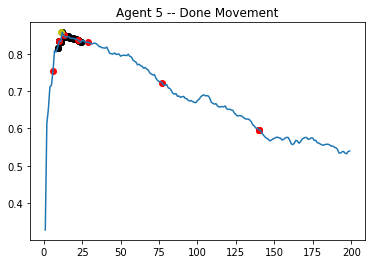

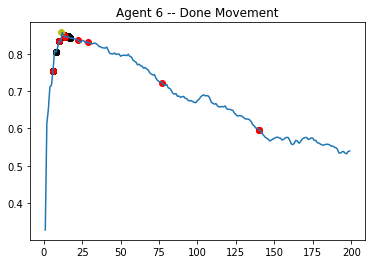

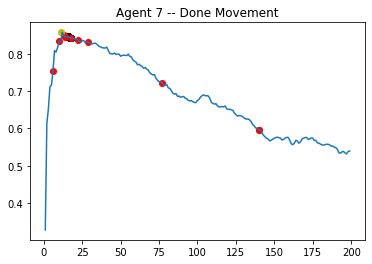

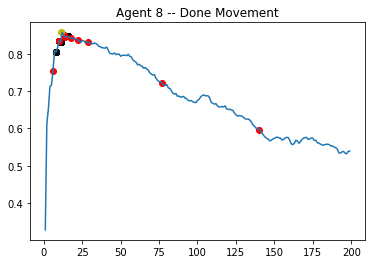

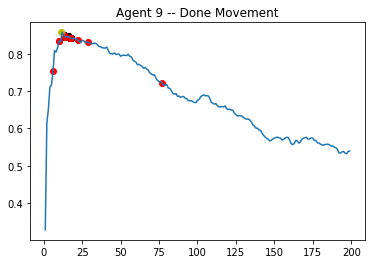

  5%|▌         | 1/20 [00:24<07:37, 24.05s/it]

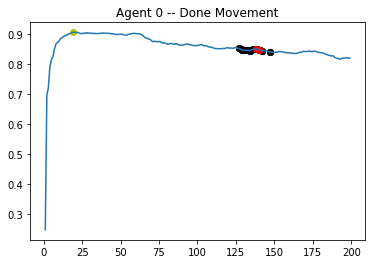

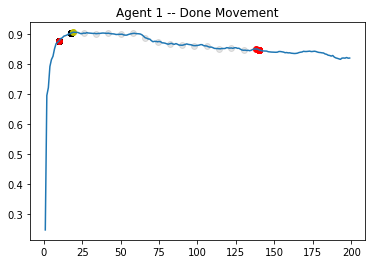

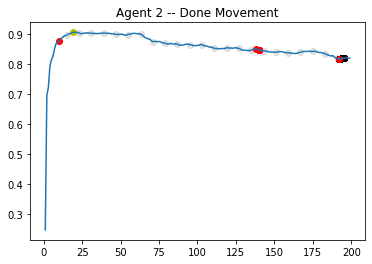

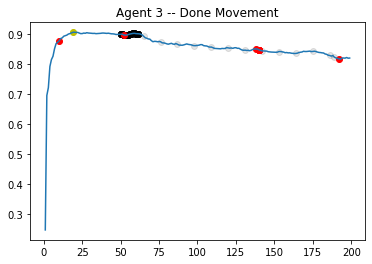

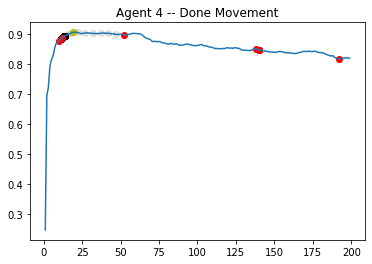

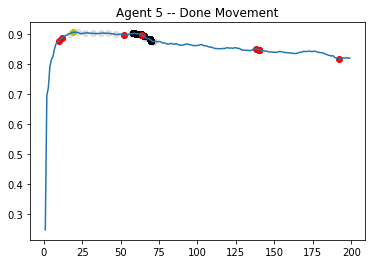

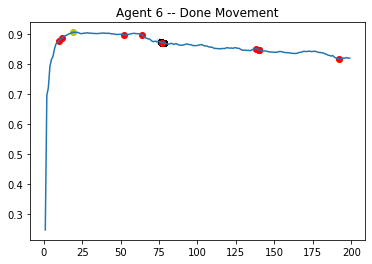

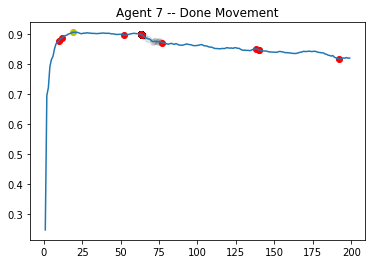

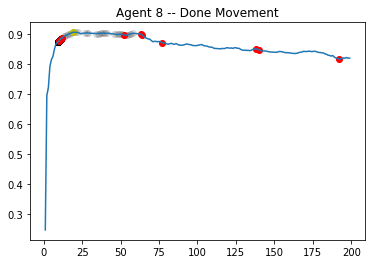

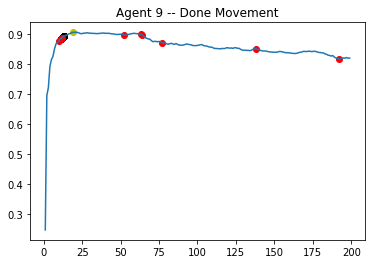

 10%|█         | 2/20 [00:48<07:13, 24.07s/it]

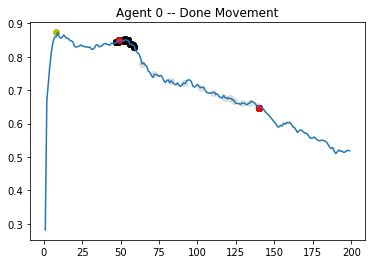

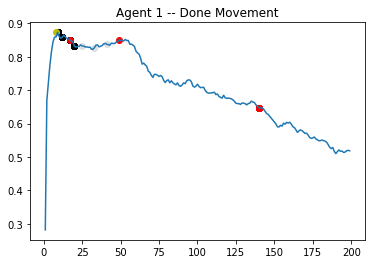

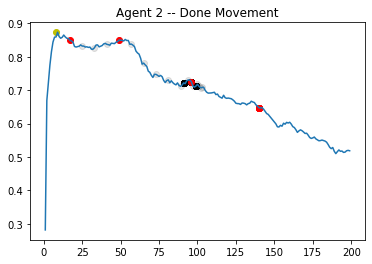

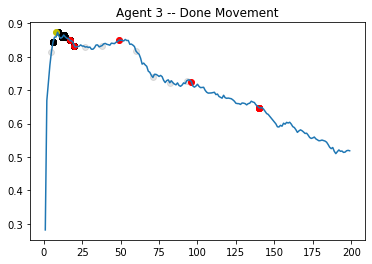

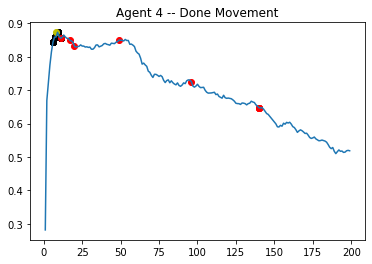

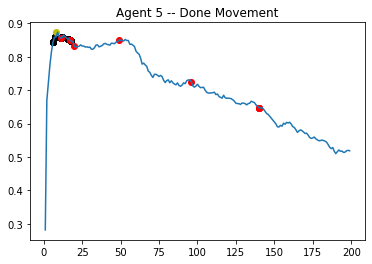

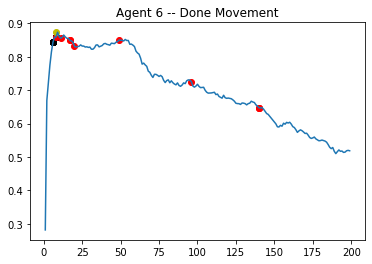

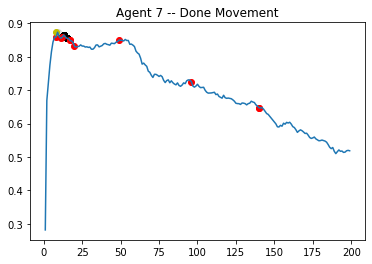

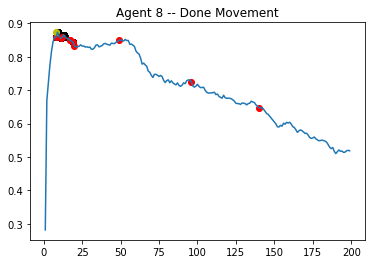

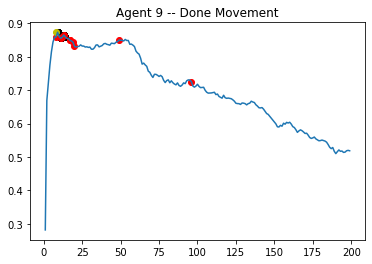

 15%|█▌        | 3/20 [01:12<06:49, 24.09s/it]

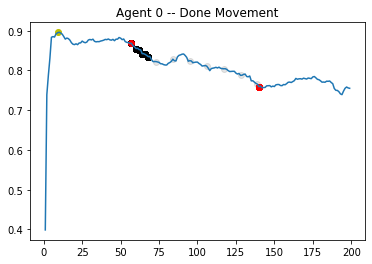

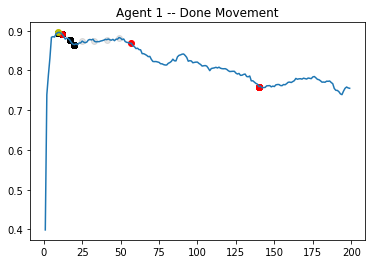

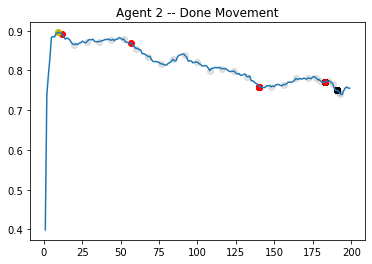

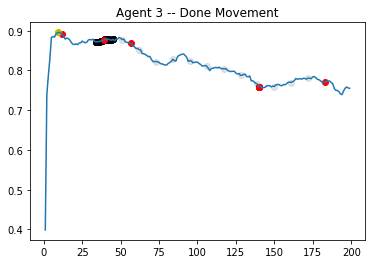

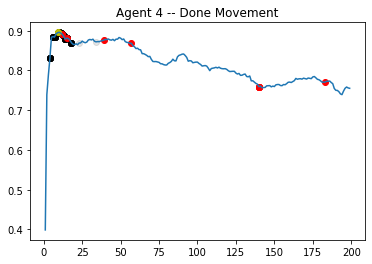

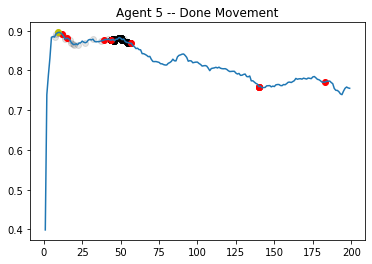

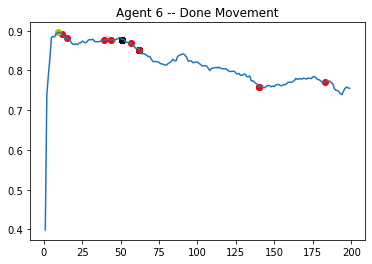

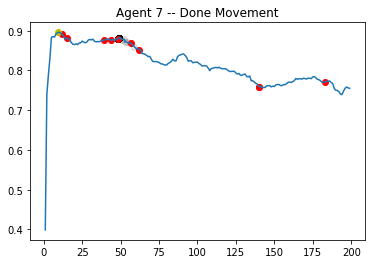

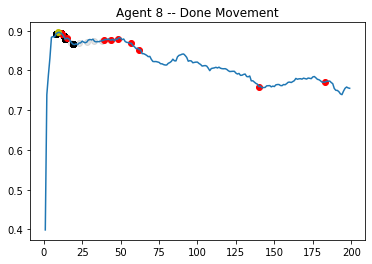

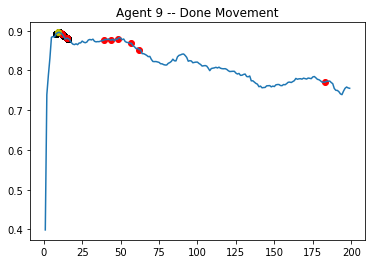

 20%|██        | 4/20 [01:36<06:25, 24.11s/it]

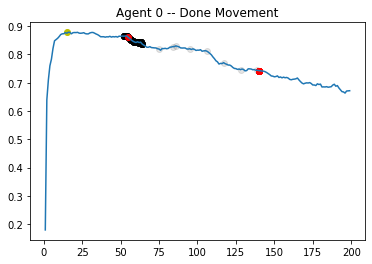

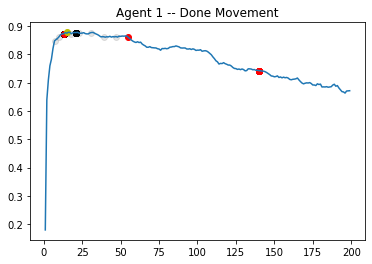

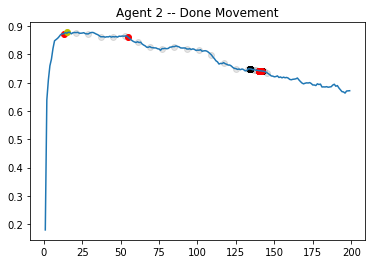

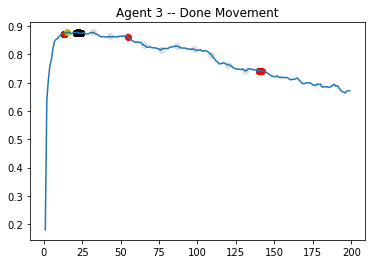

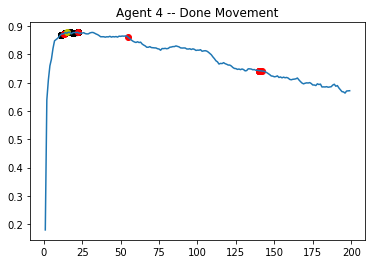

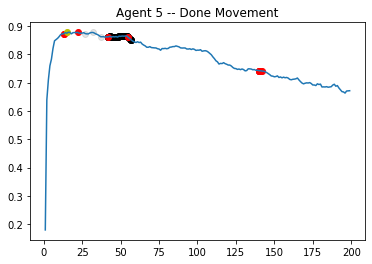

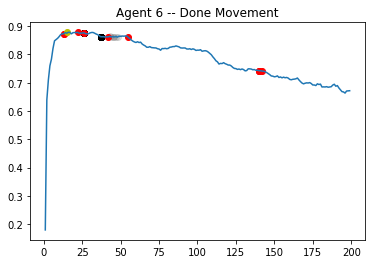

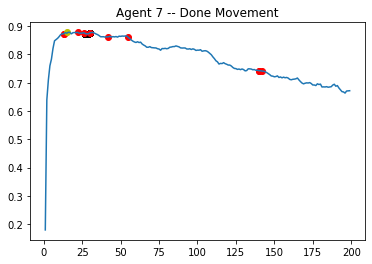

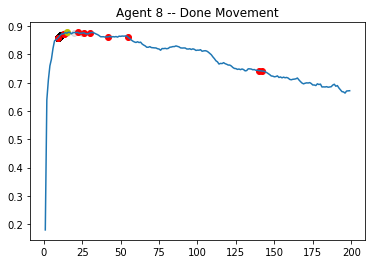

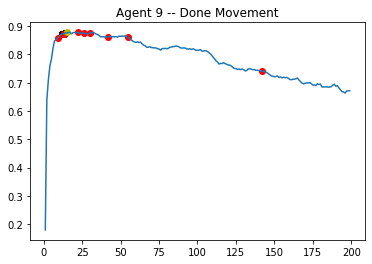

 25%|██▌       | 5/20 [02:00<06:01, 24.13s/it]

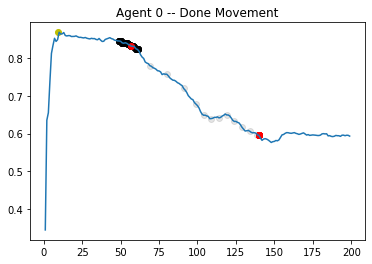

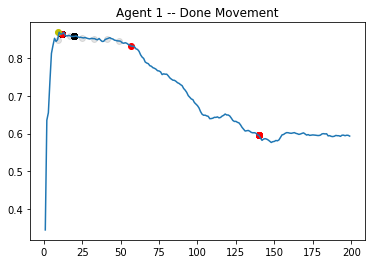

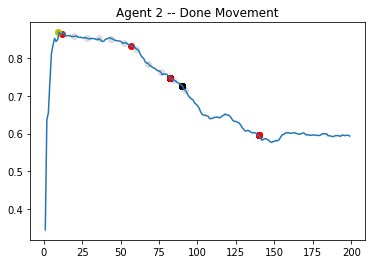

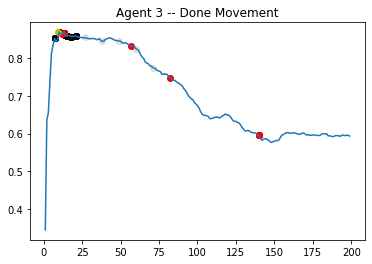

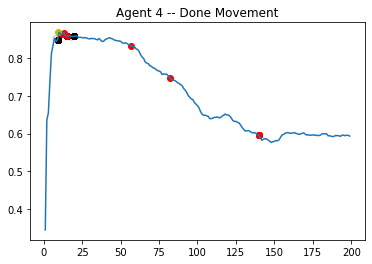

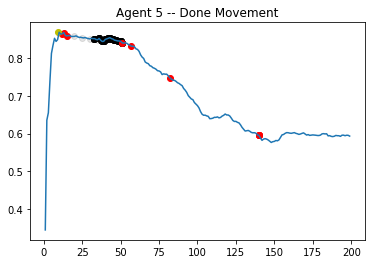

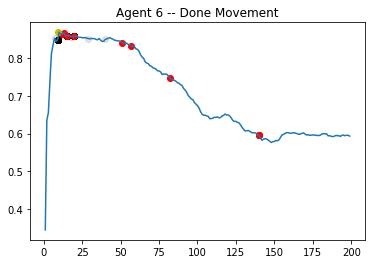

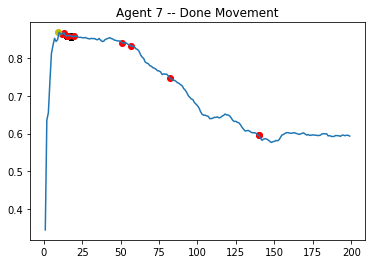

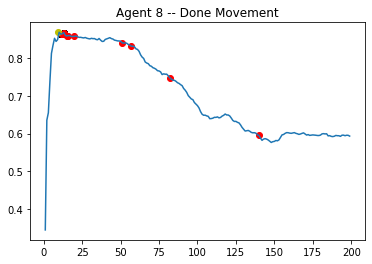

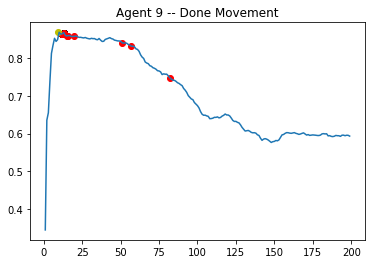

 30%|███       | 6/20 [02:24<05:37, 24.14s/it]

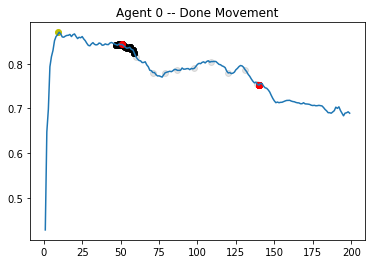

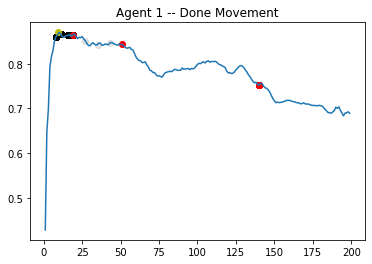

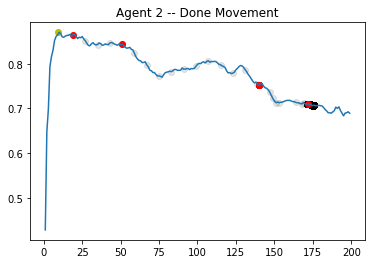

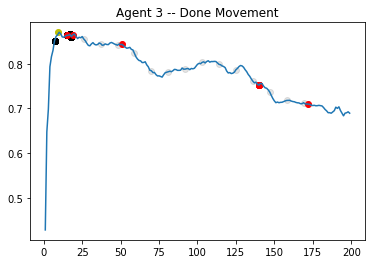

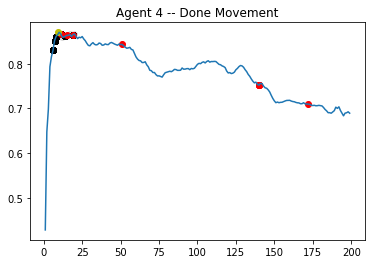

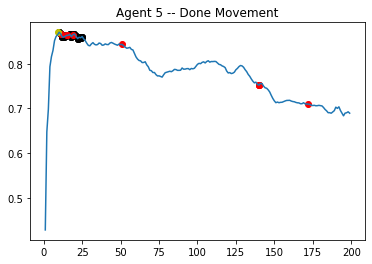

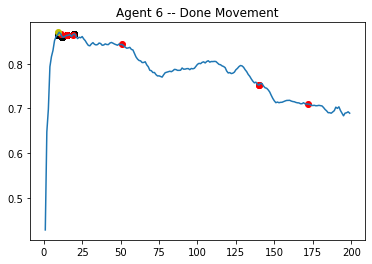

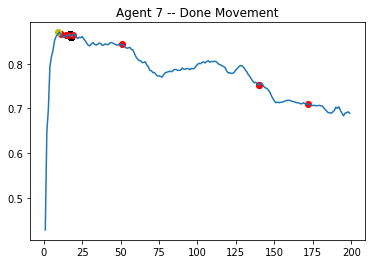

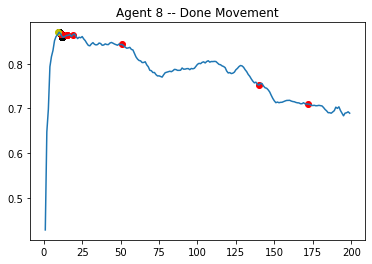

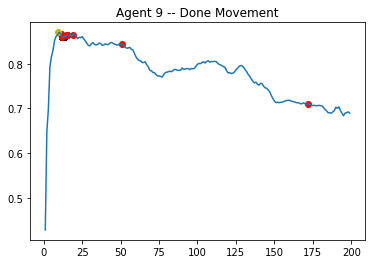

 35%|███▌      | 7/20 [02:48<05:12, 24.07s/it]

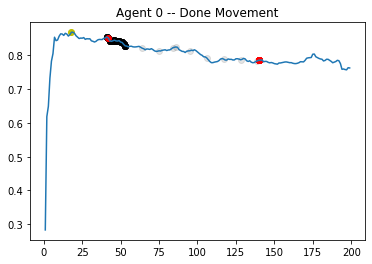

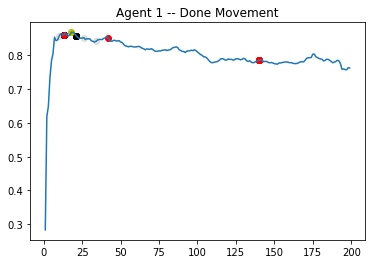

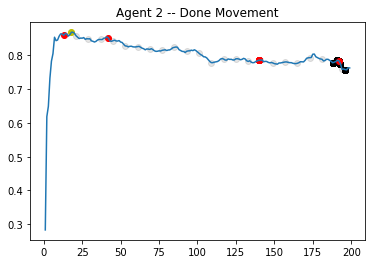

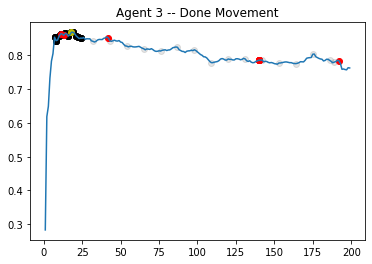

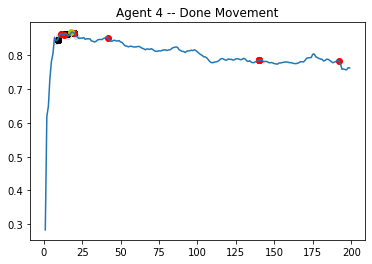

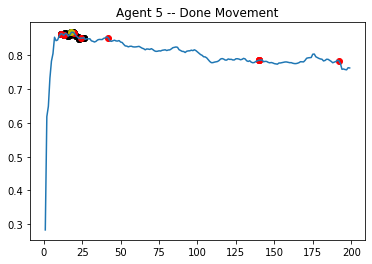

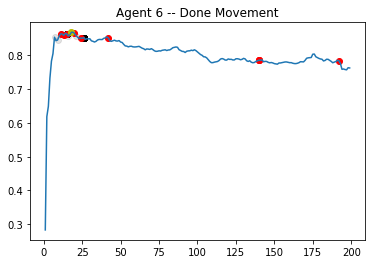

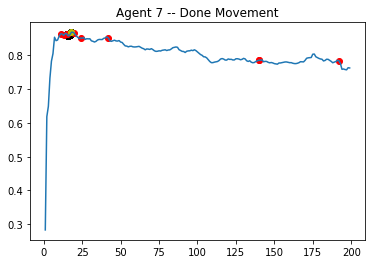

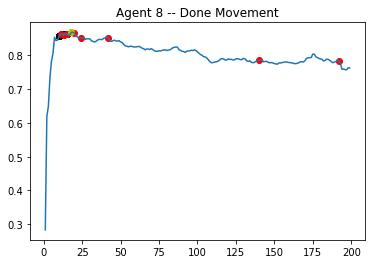

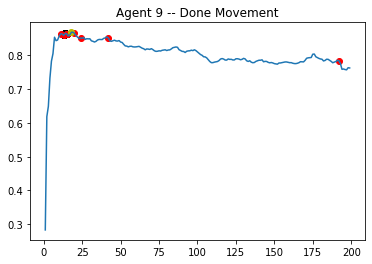

 40%|████      | 8/20 [03:12<04:48, 24.05s/it]

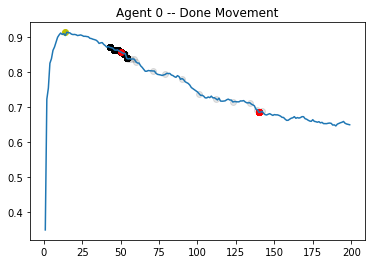

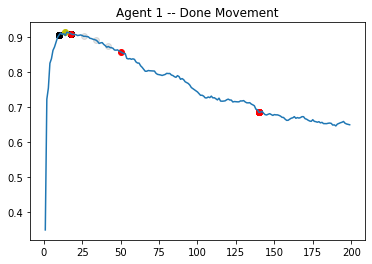

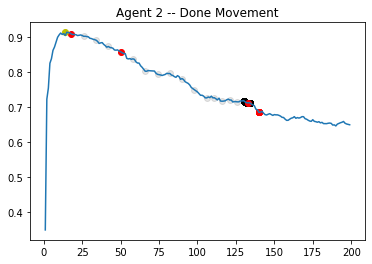

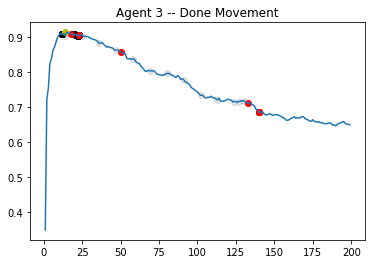

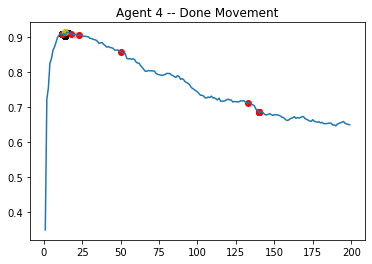

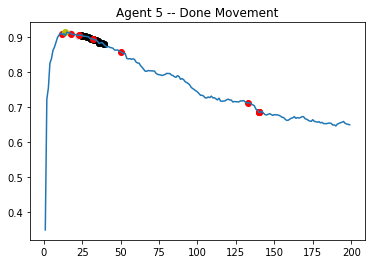

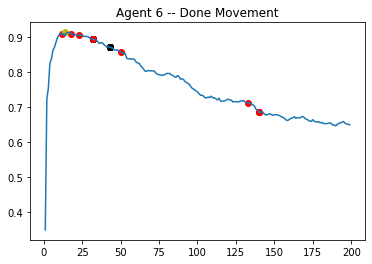

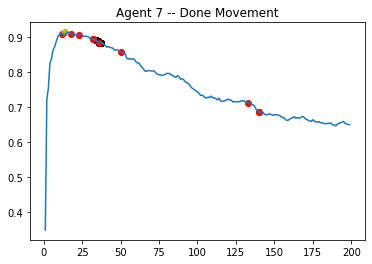

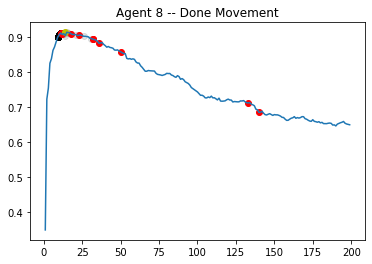

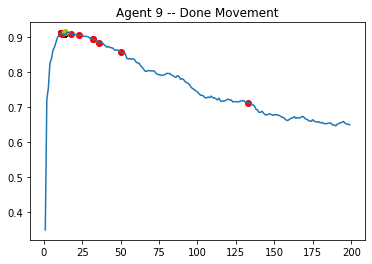

 45%|████▌     | 9/20 [03:36<04:23, 23.98s/it]

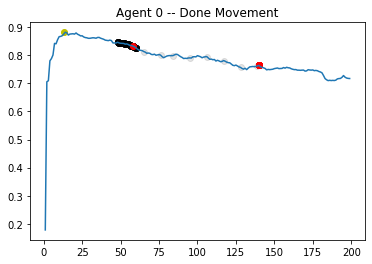

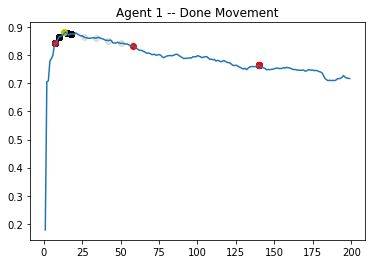

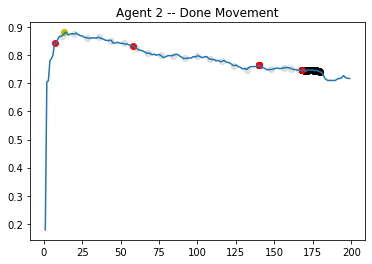

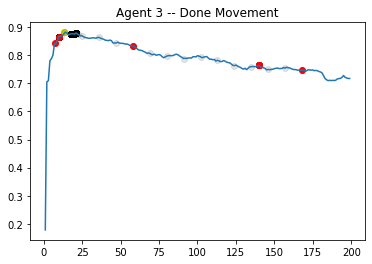

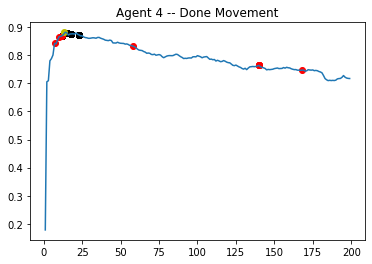

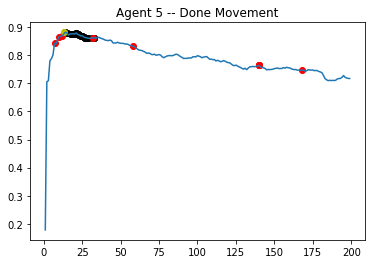

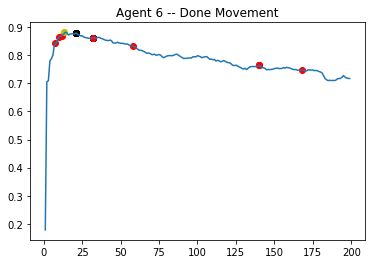

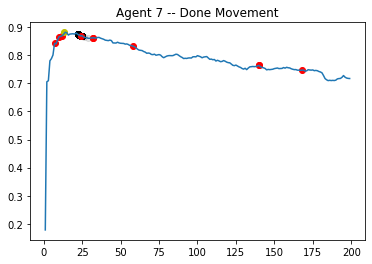

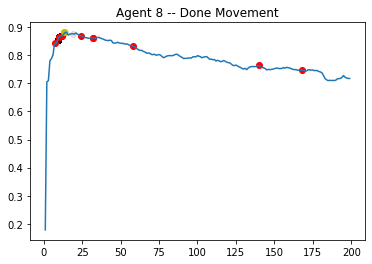

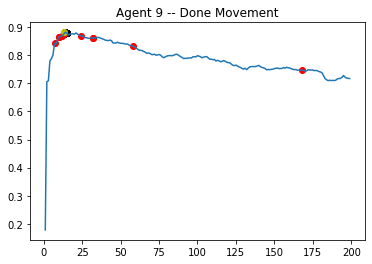

 50%|█████     | 10/20 [04:00<04:00, 24.02s/it]

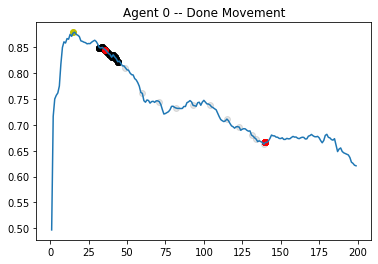

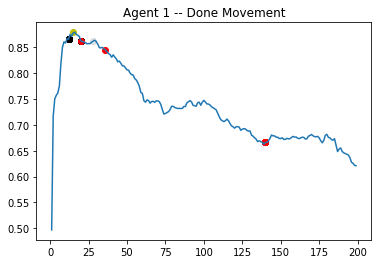

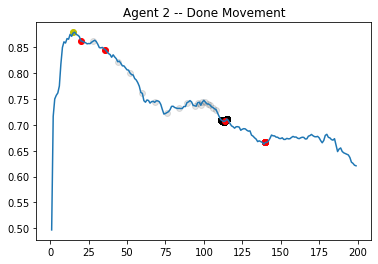

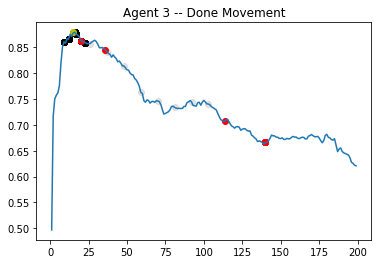

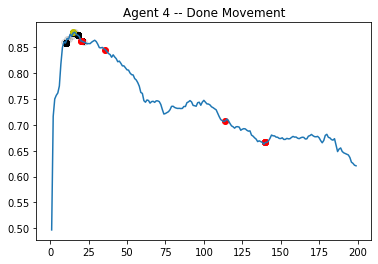

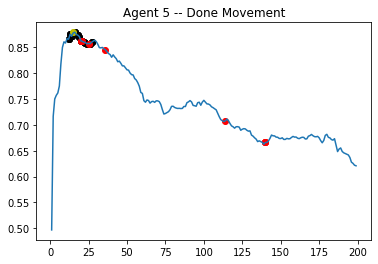

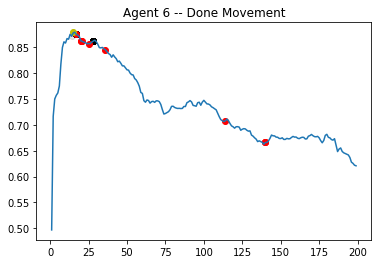

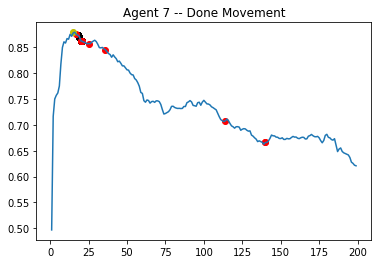

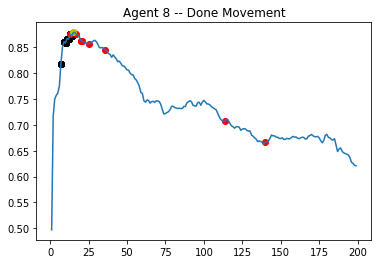

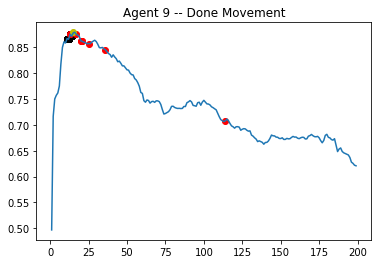

 55%|█████▌    | 11/20 [04:24<03:35, 23.99s/it]

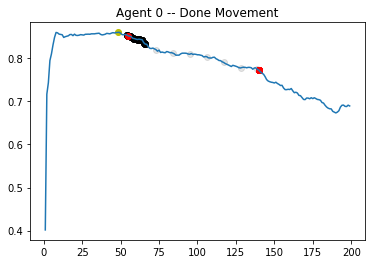

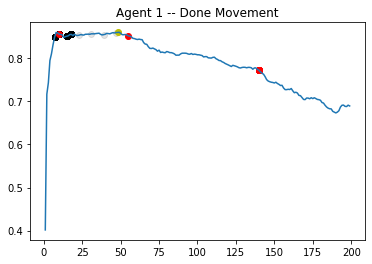

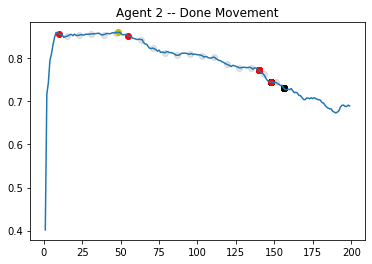

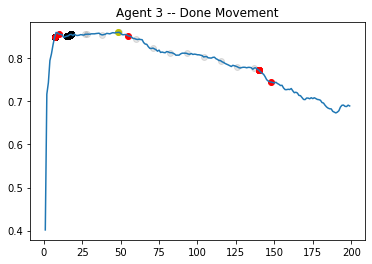

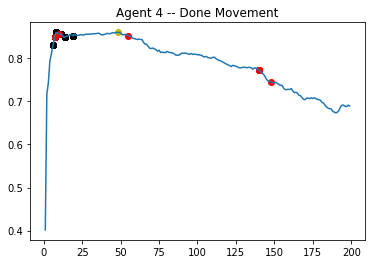

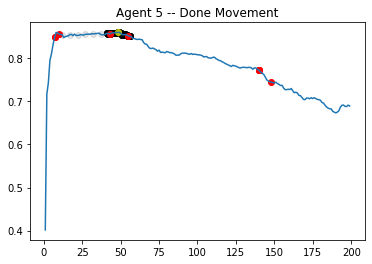

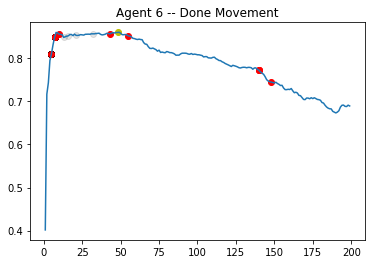

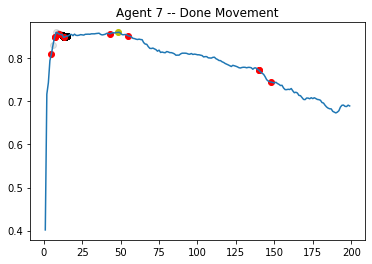

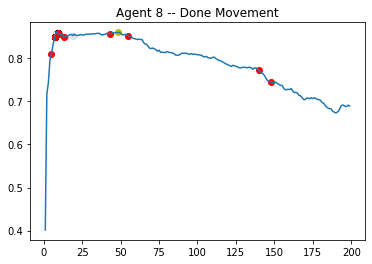

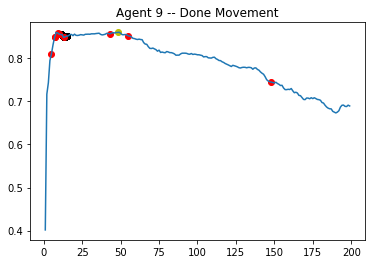

 60%|██████    | 12/20 [04:48<03:12, 24.03s/it]

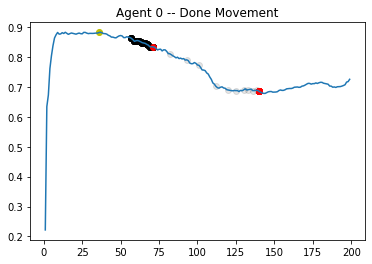

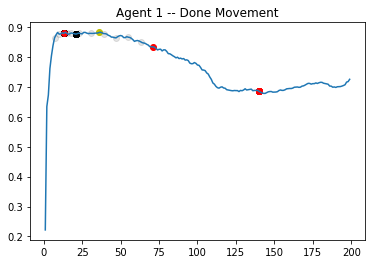

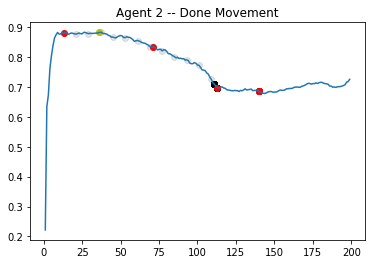

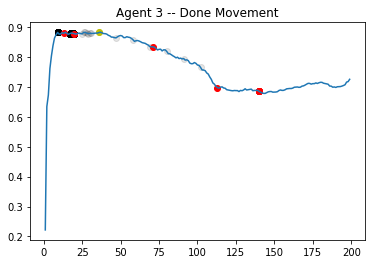

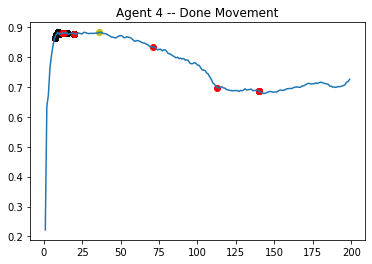

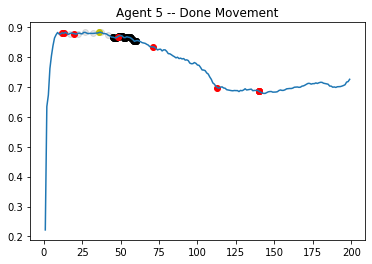

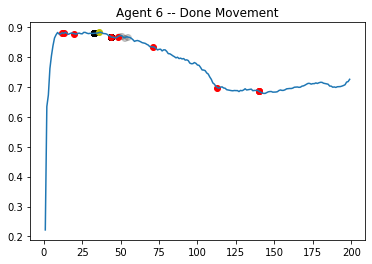

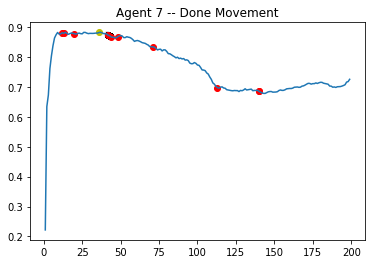

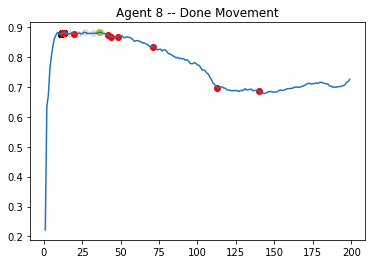

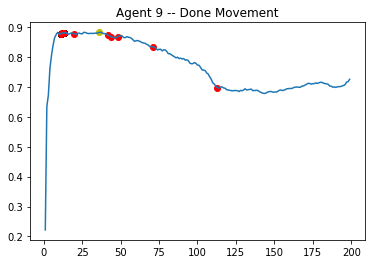

 65%|██████▌   | 13/20 [05:12<02:48, 24.07s/it]

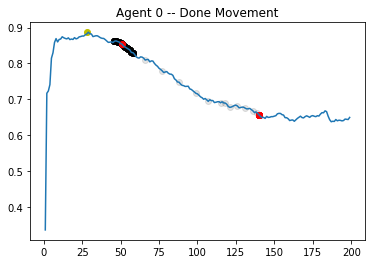

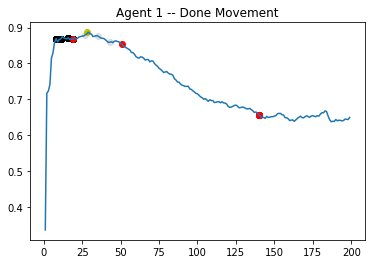

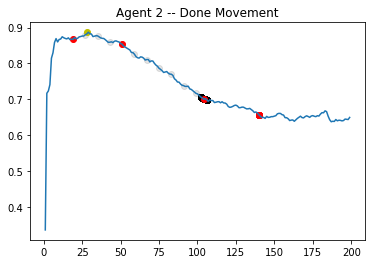

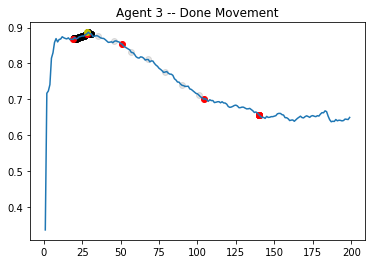

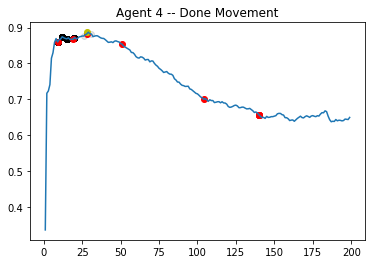

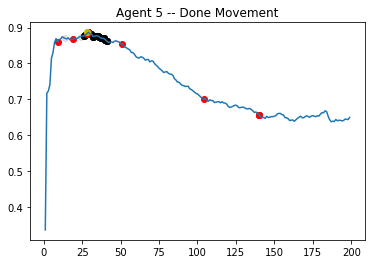

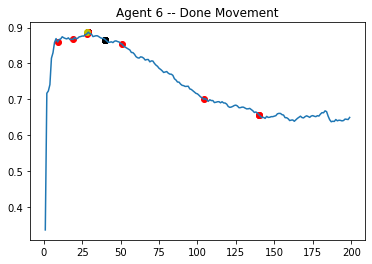

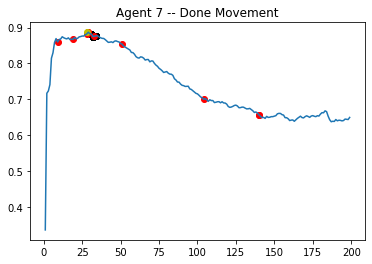

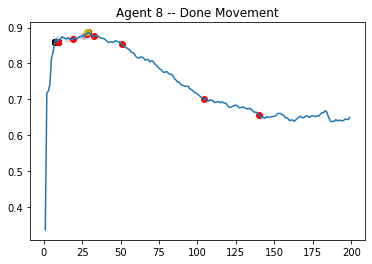

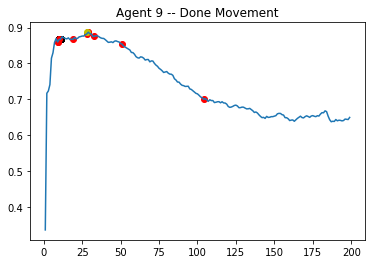

 70%|███████   | 14/20 [05:37<02:24, 24.16s/it]

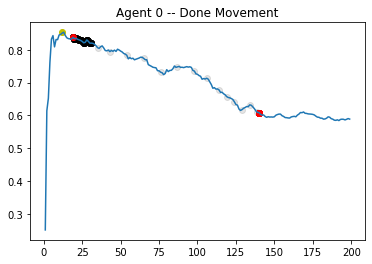

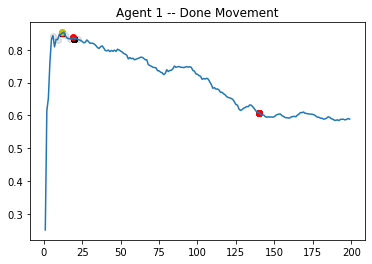

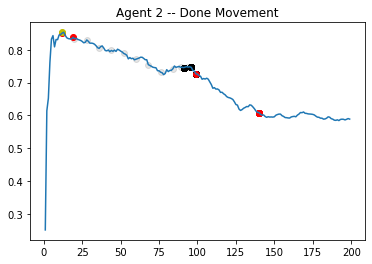

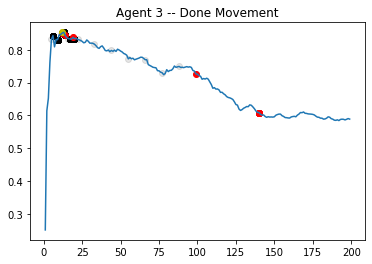

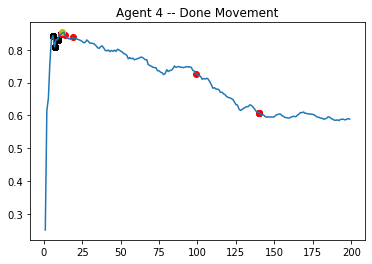

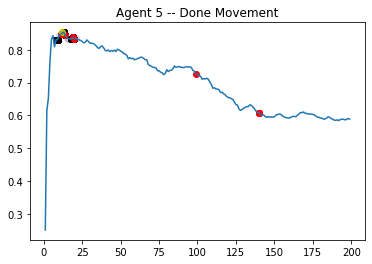

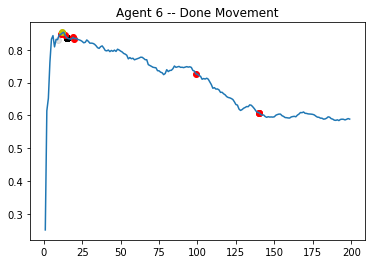

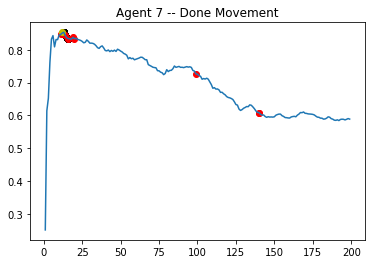

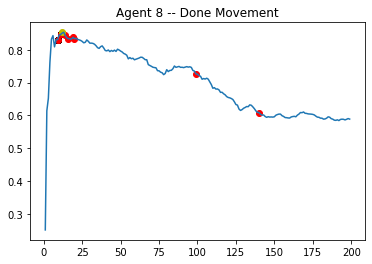

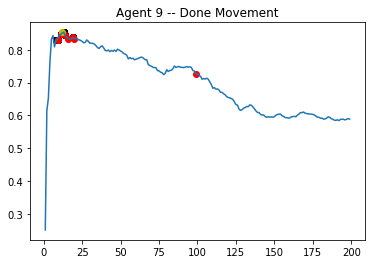

 75%|███████▌  | 15/20 [06:01<02:00, 24.08s/it]

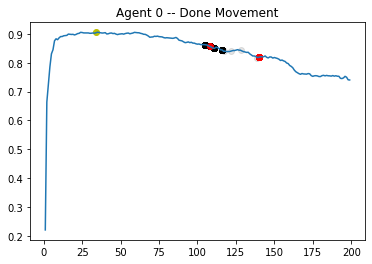

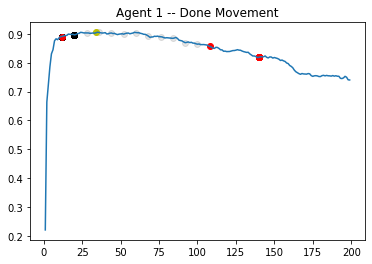

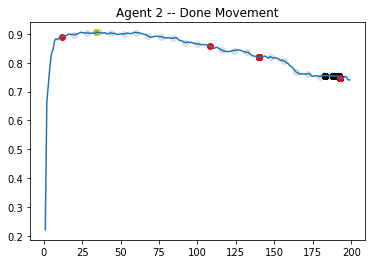

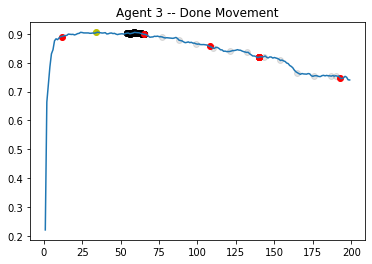

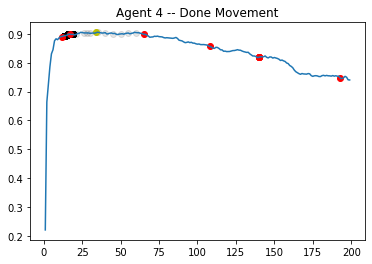

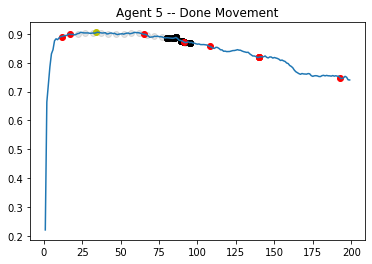

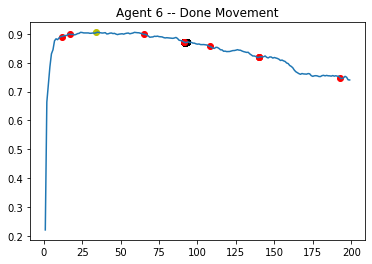

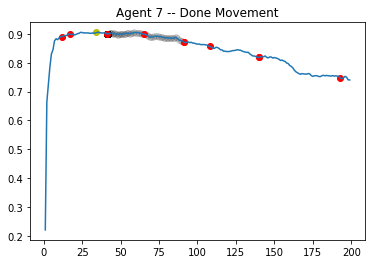

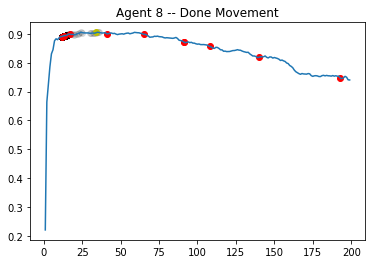

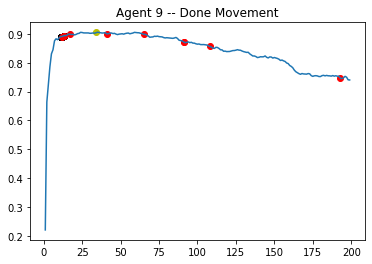

 80%|████████  | 16/20 [06:25<01:36, 24.21s/it]

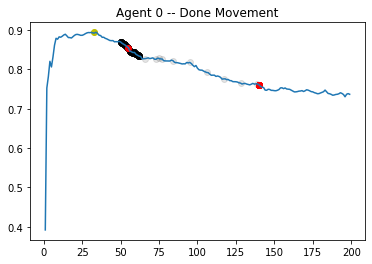

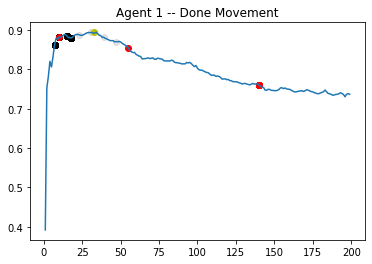

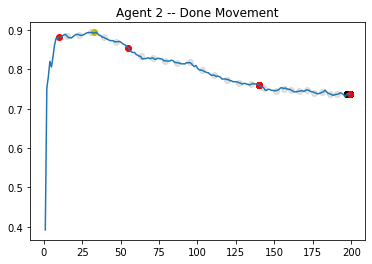

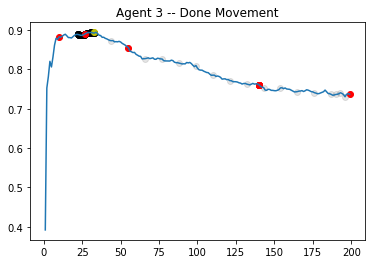

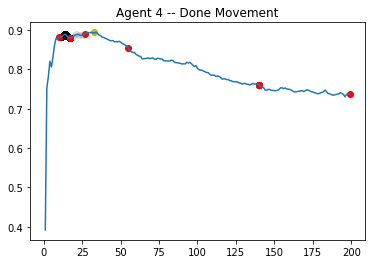

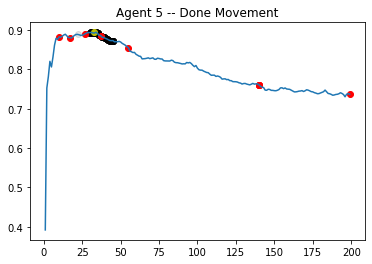

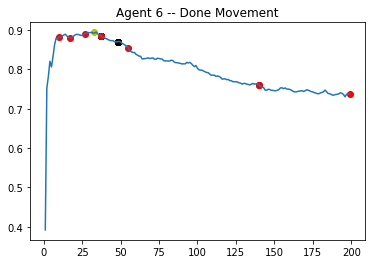

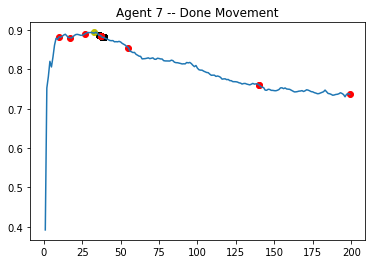

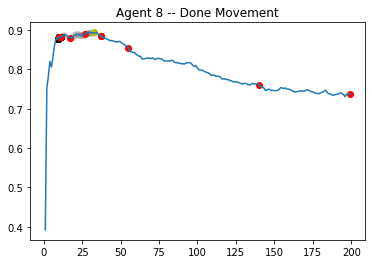

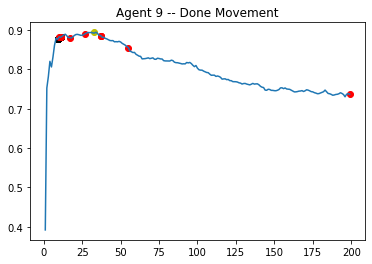

 85%|████████▌ | 17/20 [06:49<01:12, 24.19s/it]

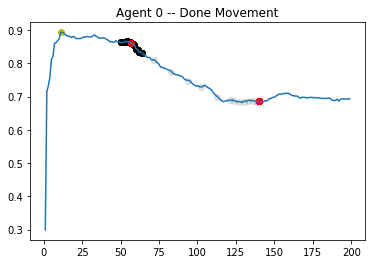

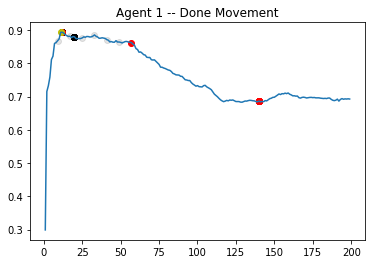

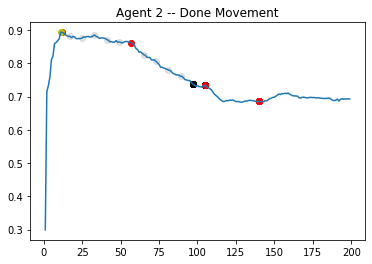

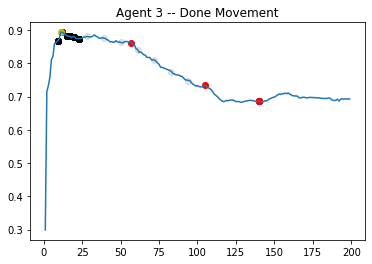

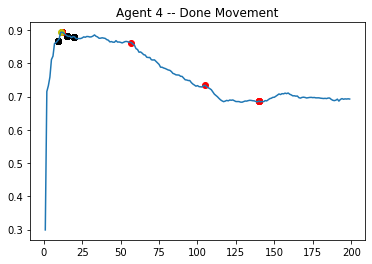

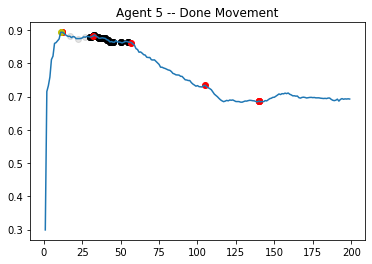

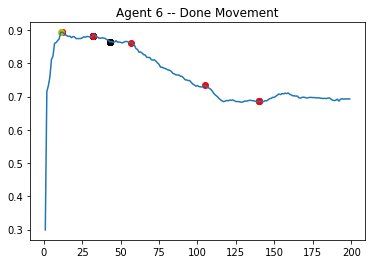

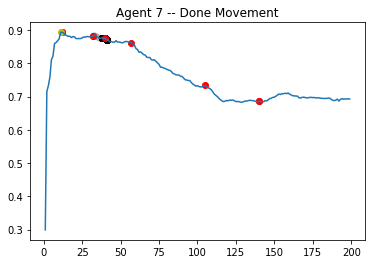

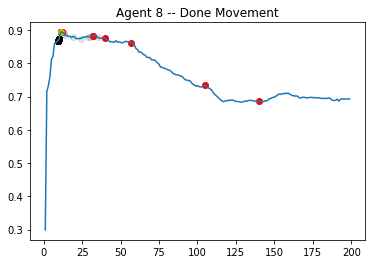

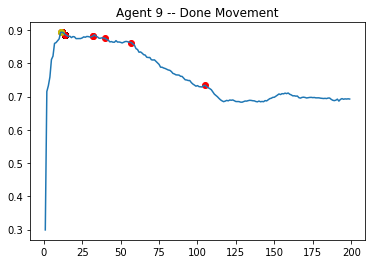

 90%|█████████ | 18/20 [07:14<00:48, 24.31s/it]

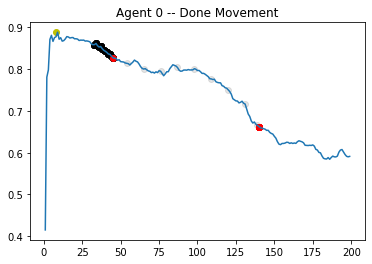

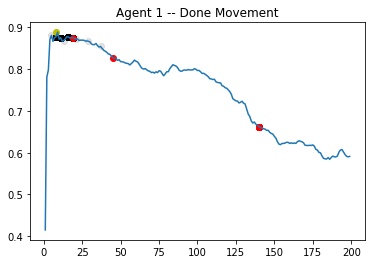

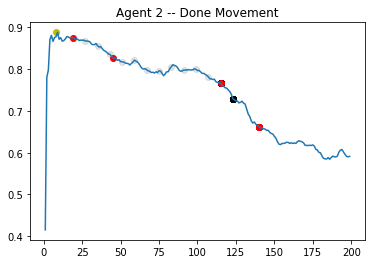

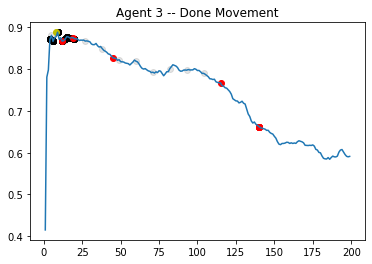

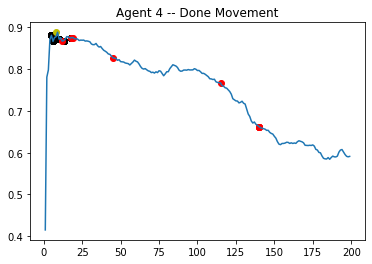

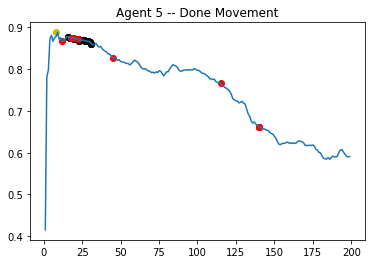

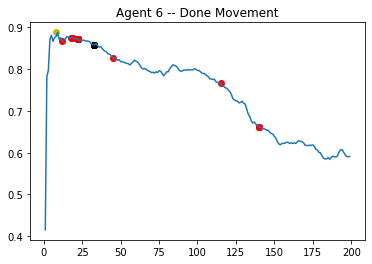

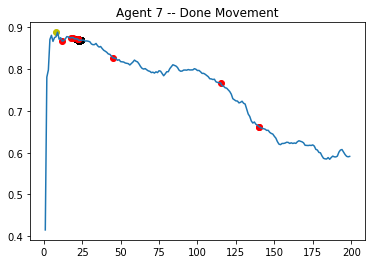

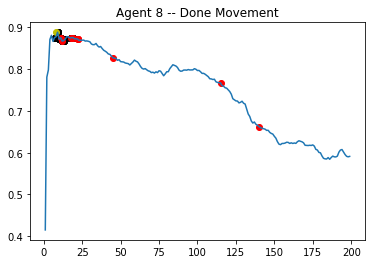

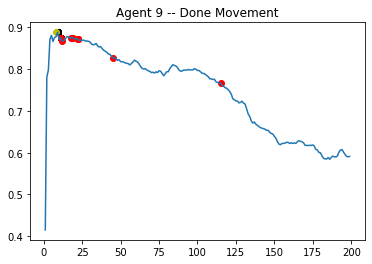

 95%|█████████▌| 19/20 [07:38<00:24, 24.35s/it]

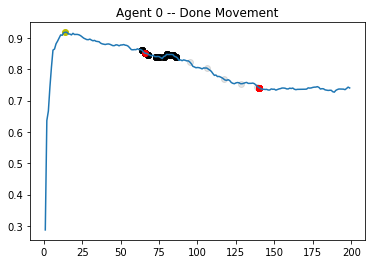

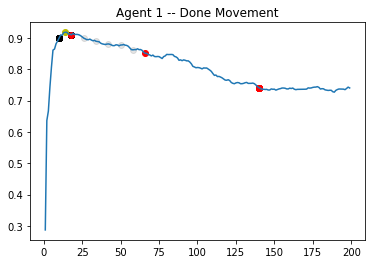

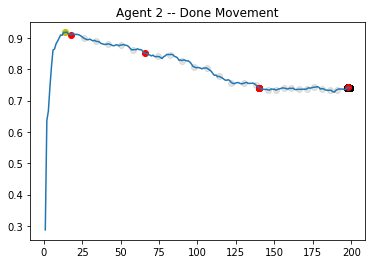

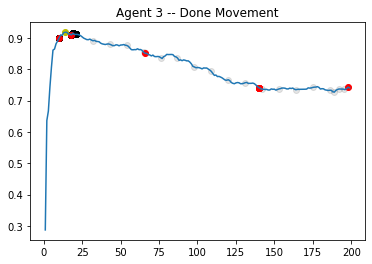

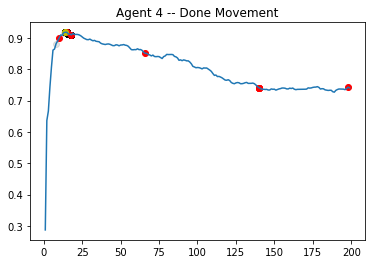

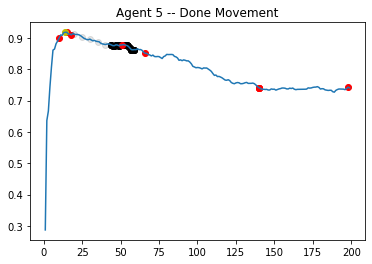

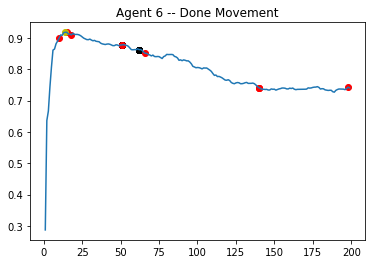

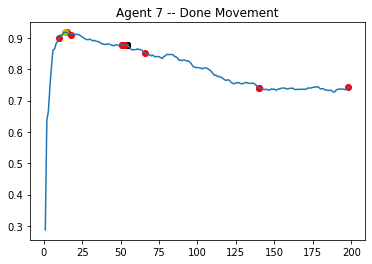

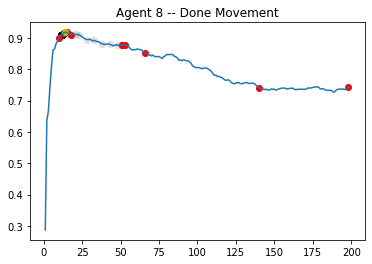

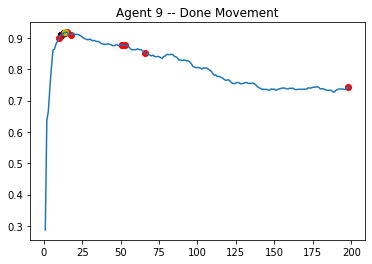

100%|██████████| 20/20 [08:03<00:00, 24.35s/it]


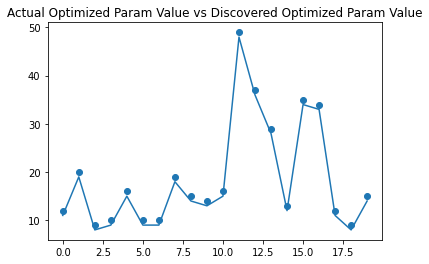

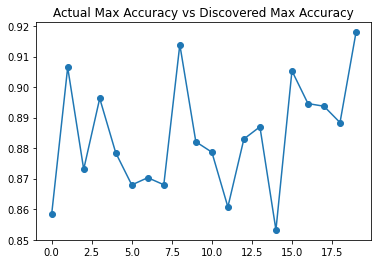

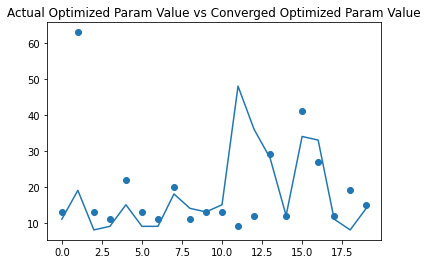

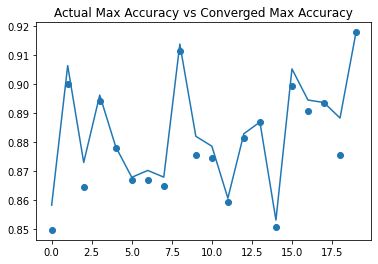

In [17]:
max_x_list = []
max_acc_list = []
past_max_x_list = []
past_max_acc_list = []
converge_x_list = []
converge_acc_list = []


n_tests = 20

for _ in tqdm(range(n_tests)):
  X = np.concatenate((X_train, X_test))
  Y = np.concatenate((Y_train, Y_test))
  train_indices = np.random.choice(X.shape[0], 300, replace=False)
  test_indices = np.array([x for x in range(X.shape[0]) if x not in train_indices])
  X_train_test = X[train_indices]
  X_test_test = X[test_indices]
  Y_train_test = Y[train_indices]
  Y_test_test = Y[test_indices]
  accuracy_list_test = []
  accuracy_lookuptb_test = {}
  for x in x_range:
    accuracy_list_test.append(calAccuracyTest(x))
    accuracy_lookuptb_test[x] = accuracy_list_test[-1]
  max_x_list.append(np.argmax(accuracy_list_test))
  max_acc_list.append(max(accuracy_list_test))
  
  next_x_test = -1
  cur_x_test = 140

  cur_detection_test = detect(detect_range, cur_x_test, accuracy_lookuptb_test)
  cur_gre_test = np.zeros(13)

  cur_state_dtc_test = cur_detection
  cur_state_gre_test = cur_gre
  cur_state_x_test = [cur_x_test]
  cur_state_test, cur_nor_state_test = norState(cur_state_dtc_test, cur_state_gre_test, cur_state_x_test, scaler_state)

  init_state_test = cur_state_test
  init_nor_state_test = cur_nor_state_test
  max_x_test = cur_x
  max_acc_test = calReward(cur_x, accuracy_lookuptb_test)

  agents_pos = [(cur_x_test, calReward(cur_x_test, accuracy_lookuptb_test))] * n_agents

  all_converged_xs = []
  all_converged_accs = []
  for i, q_model in enumerate(agents):
    for step_ctr in range(180):
      action_test = step_options[np.argmax(q_model.predict(cur_nor_state_test.reshape(1, len(cur_state))))]

      next_state_test, next_nor_state_test, next_x_test, reward_test = step(cur_state_test, action_test, cur_x_test, scaler_state, accuracy_lookuptb_test)

      reward_nor_test = scaler_reward.transform([[reward_test]])[0][0]

      if reward_test > max_acc_test:
        max_x_test = next_x_test
        max_acc_test = reward_test

      reward_nor_his.append(reward_nor)

      cur_state_test = next_state_test
      cur_nor_state_test = next_nor_state_test
      cur_x_test = next_x_test
      plt.scatter(cur_x_test, reward_test, alpha=max(step_ctr/ one_game_steps, 0.1), c='black')

    agents_pos[i] = (cur_x_test, reward_test)

    all_converged_xs.append(cur_x_test)
    all_converged_accs.append(reward_test)

    plt.scatter([pos[0] for pos in agents_pos], [pos[1] for pos in agents_pos], c='r')
    plt.scatter(max_x_list[-1],  max_acc_list[-1], c='y')
    plt.plot(x_range, accuracy_list_test)
    plt.title("Agent %d -- Done Movement"%i)
    plt.show()


  past_max_x_list.append(max_x_test)
  past_max_acc_list.append(max_acc_test)

  converge_x_list.append(all_converged_xs[np.argmax(all_converged_accs)])
  converge_acc_list.append(max(all_converged_accs))


plt.plot(range(n_tests), max_x_list)
plt.scatter(range(n_tests), past_max_x_list)
plt.title("Actual Optimized Param Value vs Discovered Optimized Param Value")
plt.show()


plt.plot(range(n_tests), max_acc_list)
plt.scatter(range(n_tests), past_max_acc_list)
plt.title("Actual Max Accuracy vs Discovered Max Accuracy")
plt.show()



plt.plot(range(n_tests), max_x_list)
plt.scatter(range(n_tests), converge_x_list)
plt.title("Actual Optimized Param Value vs Converged Optimized Param Value")
plt.show()


plt.plot(range(n_tests), max_acc_list)
plt.scatter(range(n_tests), converge_acc_list)
plt.title("Actual Max Accuracy vs Converged Max Accuracy")
plt.show()


In [15]:
plt.scatter(zip(*[(1, 2), (3, 4)]))

TypeError: ignored